# Analisis Sentimen Komentar YouTube terhadap Bencana di Sumatra

## Install dan Import library

In [1]:
!pip install Sastrawi
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 14.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import string
import requests
from io import BytesIO
import json
import ast
from collections import Counter
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import CountVectorizer

## Preprocessing

In [ ]:
default = pd.read_csv('bencanaNasionalSumatra.csv')
default.head()

,comment_id,video_id,video_url,channel_name,author,comment,lang,like_count,published_at
0,UgzPrZrnACcZ49xPqtd4AaABAg,4loaVrhp75Q,https://www.youtube.com/watch?v=4loaVrhp75Q,Ferry Irwandi,@ferryirwandi,Lekas pulih Bumi Andalasku!,id,4K,2025-11-30 10:22:16.626996
1,UgysXqZvGeVWTgHbrfV4AaABAg,4loaVrhp75Q,https://www.youtube.com/watch?v=4loaVrhp75Q,Ferry Irwandi,@Jivananta-e7y,Prabowo dari dulu jg punya lahan sawit d Sumat...,id,0,2025-12-30 10:22:17.045820
2,Ugx-C9kwMFiF8ohhBeF4AaABAg,4loaVrhp75Q,https://www.youtube.com/watch?v=4loaVrhp75Q,Ferry Irwandi,@RomeoRomeo-r2h,Lahir di Jambi asal payuhkumbuah,id,0,2025-12-29 10:22:17.050351
3,Ugxh-sprQtjLePsUtGp4AaABAg,4loaVrhp75Q,https://www.youtube.com/watch?v=4loaVrhp75Q,Ferry Irwandi,@GlobalHistory-z7j,👍👍👍,NaN,0,2025-12-29 10:22:17.053696
4,Ugy-X-qPAU4LjU6MaKt4AaABAg,4loaVrhp75Q,https://www.youtube.com/watch?v=4loaVrhp75Q,Ferry Irwandi,@tolesatrio5705,PROVOKATOR SESUNGGUHNYA,de,0,2025-12-28 10:22:17.055518


In [ ]:
# ambil 3 kolom
df = default[['channel_name', 'like_count', 'comment']]
df.head()

,channel_name,like_count,comment
0,Ferry Irwandi,4K,Lekas pulih Bumi Andalasku!
1,Ferry Irwandi,0,Prabowo dari dulu jg punya lahan sawit d Sumat...
2,Ferry Irwandi,0,Lahir di Jambi asal payuhkumbuah
3,Ferry Irwandi,0,👍👍👍
4,Ferry Irwandi,0,PROVOKATOR SESUNGGUHNYA


In [ ]:
# modifikasi nama kolom agar lebih mudah
df = df[['channel_name', 'like_count', 'comment']]
df.columns = ['channel', 'likes', 'comment']
df.head()

,channel,likes,comment
0,Ferry Irwandi,4K,Lekas pulih Bumi Andalasku!
1,Ferry Irwandi,0,Prabowo dari dulu jg punya lahan sawit d Sumat...
2,Ferry Irwandi,0,Lahir di Jambi asal payuhkumbuah
3,Ferry Irwandi,0,👍👍👍
4,Ferry Irwandi,0,PROVOKATOR SESUNGGUHNYA


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27433 entries, 0 to 27432
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   channel  27433 non-null  object
 1   likes    27433 non-null  object
 2   comment  27433 non-null  object
dtypes: object(3)
memory usage: 643.1+ KB


In [ ]:
df['channel'].value_counts()

,count
channel,
CURHAT BANG Denny Sumargo,14761
Ferry Irwandi,6154
Sepulang Sekolah,3674
Kamar JERI,2844


In [ ]:
# lihat komentar yang duplikat
df['comment'].duplicated().sum()

np.int64(1137)

In [ ]:
# lihat contoh baris yang duplikat
df[df['comment'].duplicated(keep=False)].head(10)

,channel,likes,comment
0,Ferry Irwandi,4K,Lekas pulih Bumi Andalasku!
3,Ferry Irwandi,0,👍👍👍
8,Ferry Irwandi,0,hidup BOWO hidup BAHLIL hidup. DPR ROMPI anti ...
9,Ferry Irwandi,0,hidup BOWO hidup BAHLIL hidup. DPR ROMPI anti ...
20,Ferry Irwandi,74,Penetapan status menjadi Bencana Nasional tent...
21,Ferry Irwandi,4,​ @fitrinurasiah2084 semenjak mulyono habis wa...
22,Ferry Irwandi,1,​ @fitrinurasiah2084 bang ferry Anda emang pa...
23,Ferry Irwandi,0,​ @fitrinurasiah2084 STATUS BENCANA NASIONAL I...
24,Ferry Irwandi,25,Aku pengen banget ya sebagai orang Minang dan ...
25,Ferry Irwandi,3,​ @BRAVOO-z2i hidup dekengane pusat


In [ ]:
# buang data duplikat
df.drop_duplicates(subset=['comment'], keep='first', inplace=True)
df['comment'].duplicated().sum()

np.int64(0)

In [ ]:
df.isnull().sum()

,0
channel,0
likes,0
comment,0


In [ ]:
# definisi fungsi cleaning
def remove_url(text):
    if isinstance(text, str):
        return re.sub(r'https?://\S+|www\.\S+', '', text)
    return text

def remove_usernames(text):
    if isinstance(text, str):
        return re.sub(r'@\w+', '', text)
    return text

def remove_emoji(text):
    if isinstance(text, str):
        emoji_pattern = re.compile(u"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001F004-\U0001F0CF\U0001F1E0-\U0001F1FF]+")
        return emoji_pattern.sub(r'', text)
    return text

def remove_symbols(text):
    if isinstance(text, str):
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

def remove_numbers(text):
    if isinstance(text, str):
        return re.sub(r'\d', '', text)
    return text

In [ ]:
def load_kamus(file_path, sheet_name="colloquial-indonesian-lexicon"):
    df = pd.read_excel(file_path, sheet_name=sheet_name)

    # jadikan dictionary: {"woww": "wow", "aminn": "amin"}
    kamus = dict(zip(df["tidak_baku"].astype(str), df["kata_baku"].astype(str)))
    return kamus

# pakai
kamus_slang_sendiri = load_kamus("kamuskatabaku.xlsx")

In [ ]:
# terapkan cleaning
df['cleaning'] = df['comment'].apply(remove_url)
df['cleaning'] = df['cleaning'].apply(remove_usernames)
df['cleaning'] = df['cleaning'].apply(remove_emoji)
df['cleaning'] = df['cleaning'].apply(remove_symbols)
df['cleaning'] = df['cleaning'].apply(remove_numbers)
df['cleaning'] = df['cleaning'].apply(lambda x: ' '.join(x.split()) if isinstance(x, str) else x)

# case folding / kecilkan huruf
df['case_folding'] = df['cleaning'].apply(lambda x: x.lower() if isinstance(x, str) else x)

# normalisasi (ubah kata tidak baku menjadi baku)
def normalize_text(text, kamus):
    if isinstance(text, str):
        words = text.split()
        return ' '.join([kamus[word] if word in kamus else word for word in words])
    return text

# normalisasi / ubah kata tidak baku(slang) jadi baku pakai kamus tersendiri
df['normalisasi'] = df['case_folding'].apply(lambda x: normalize_text(x, kamus_slang_sendiri))
df.head(10)

,channel,likes,comment,cleaning,case_folding,normalisasi
0,Ferry Irwandi,4K,Lekas pulih Bumi Andalasku!,Lekas pulih Bumi Andalasku,lekas pulih bumi andalasku,lekas pulih bumi andalasku
1,Ferry Irwandi,0,Prabowo dari dulu jg punya lahan sawit d Sumat...,Prabowo dari dulu jg punya lahan sawit d Sumat...,prabowo dari dulu jg punya lahan sawit d sumat...,prabowo dari dulu juga punya lahan sawit di su...
2,Ferry Irwandi,0,Lahir di Jambi asal payuhkumbuah,Lahir di Jambi asal payuhkumbuah,lahir di jambi asal payuhkumbuah,lahir di jambi asal payuhkumbuah
3,Ferry Irwandi,0,👍👍👍,,,
4,Ferry Irwandi,0,PROVOKATOR SESUNGGUHNYA,PROVOKATOR SESUNGGUHNYA,provokator sesungguhnya,provokator sesungguhnya
5,Ferry Irwandi,0,"Menurut aku ya,..Kok lebih pinter bg feri Irwa...",Menurut aku yaKok lebih pinter bg feri Irwandi...,menurut aku yakok lebih pinter bg feri irwandi...,menurut aku yakok lebih pintar bang feri irwan...
6,Ferry Irwandi,0,Biar pintar baca ini : Bencana nasional di Ind...,Biar pintar baca ini Bencana nasional di Indon...,biar pintar baca ini bencana nasional di indon...,biar pintar baca ini bencana nasional di indon...
7,Ferry Irwandi,1,"Seseorang pernah berkata ""jangan takut defores...",Seseorang pernah berkata jangan takut deforest...,seseorang pernah berkata jangan takut deforest...,seseorang pernah berkata jangan takut deforest...
8,Ferry Irwandi,0,hidup BOWO hidup BAHLIL hidup. DPR ROMPI anti ...,hidup BOWO hidup BAHLIL hidup DPR ROMPI anti p...,hidup bowo hidup bahlil hidup dpr rompi anti p...,hidup bowo hidup bahlil hidup dpr rompi anti p...
10,Ferry Irwandi,0,Ferry.....jadikan keadaan susah di Acheh menja...,Ferryjadikan keadaan susah di Acheh menjadi se...,ferryjadikan keadaan susah di acheh menjadi se...,ferryjadikan keadaan susah di acheh menjadi se...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26296 entries, 0 to 27432
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   channel       26296 non-null  object
 1   likes         26296 non-null  object
 2   comment       26296 non-null  object
 3   cleaning      26296 non-null  object
 4   case_folding  26296 non-null  object
 5   normalisasi   26296 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


In [ ]:
# ganti string kosong menjadi NaN
df[['cleaning', 'case_folding', 'normalisasi']] = df[['cleaning', 'case_folding', 'normalisasi']].replace(r'^\s*$', np.nan, regex=True)

print("Jumlah baris kosong")
df[['cleaning', 'case_folding', 'normalisasi']].isnull().sum()

Jumlah baris kosong


,0
cleaning,203
case_folding,203
normalisasi,203


In [ ]:
# hapus baris NaN
df = df.dropna(subset=['cleaning', 'case_folding', 'normalisasi'])

# reset index agar nomor baris kembali berurutan
df.reset_index(drop=True, inplace=True)
df[['cleaning', 'case_folding', 'normalisasi']].isnull().sum()

,0
cleaning,0
case_folding,0
normalisasi,0


In [ ]:
# tokenize
def tokenize(text):
  if isinstance(text, str):
    tokens = text.split()
    return tokens
  return []

df['tokenize']  = df['normalisasi'].apply(tokenize)
df.head()

,channel,likes,comment,cleaning,case_folding,normalisasi,tokenize
0,Ferry Irwandi,4K,Lekas pulih Bumi Andalasku!,Lekas pulih Bumi Andalasku,lekas pulih bumi andalasku,lekas pulih bumi andalasku,"[lekas, pulih, bumi, andalasku]"
1,Ferry Irwandi,0,Prabowo dari dulu jg punya lahan sawit d Sumat...,Prabowo dari dulu jg punya lahan sawit d Sumat...,prabowo dari dulu jg punya lahan sawit d sumat...,prabowo dari dulu juga punya lahan sawit di su...,"[prabowo, dari, dulu, juga, punya, lahan, sawi..."
2,Ferry Irwandi,0,Lahir di Jambi asal payuhkumbuah,Lahir di Jambi asal payuhkumbuah,lahir di jambi asal payuhkumbuah,lahir di jambi asal payuhkumbuah,"[lahir, di, jambi, asal, payuhkumbuah]"
3,Ferry Irwandi,0,PROVOKATOR SESUNGGUHNYA,PROVOKATOR SESUNGGUHNYA,provokator sesungguhnya,provokator sesungguhnya,"[provokator, sesungguhnya]"
4,Ferry Irwandi,0,"Menurut aku ya,..Kok lebih pinter bg feri Irwa...",Menurut aku yaKok lebih pinter bg feri Irwandi...,menurut aku yakok lebih pinter bg feri irwandi...,menurut aku yakok lebih pintar bang feri irwan...,"[menurut, aku, yakok, lebih, pintar, bang, fer..."


In [ ]:
# lihat frekuensi kata
all_words_clean = []
for sublist in df['tokenize']:
    if isinstance(sublist, list):
        all_words_clean.extend(sublist)

word_frequencies_clean = Counter(all_words_clean)
word_freq_df_clean = pd.DataFrame(word_frequencies_clean.most_common(20), columns=['Word', 'Frequency'])

print("Top 20 Kata Teratas")
word_freq_df_clean

Top 20 Kata Teratas


,Word,Frequency
0,yang,15306
1,di,10613
2,tidak,10015
3,dan,8856
4,ini,6663
5,ya,5661
6,bencana,5287
7,itu,4776
8,sudah,4681
9,ada,4277


In [ ]:
# stopword removal : hapus kata kata umum yang tidak memiliki makna
factory = StopWordRemoverFactory()
stopword_std = factory.get_stop_words()

def remove_stopwords(text_list):
    if isinstance(text_list, list):
        return [word for word in text_list if word not in stopword_std]
    return text_list

# terapkan pada kolom tokenize
df['stopword_before'] = df['tokenize'].apply(remove_stopwords)

# lihat frekuensi kata
all_words_clean = []
for sublist in df['stopword_before']:
    if isinstance(sublist, list):
        all_words_clean.extend(sublist)

word_frequencies_clean = Counter(all_words_clean)
word_freq_df_clean = pd.DataFrame(word_frequencies_clean.most_common(20), columns=['Word', 'Frequency'])

print("Top 20 Kata Teratas")
word_freq_df_clean

Top 20 Kata Teratas


,Word,Frequency
0,bencana,5287
1,pemerintah,4039
2,kalau,3532
3,indonesia,3186
4,orang,3057
5,jadi,2743
6,rakyat,2570
7,sumatra,2466
8,sama,2449
9,negara,2328


In [ ]:
# terapkan stopword removal dan kata custom
factory = StopWordRemoverFactory()
stopword_std = factory.get_stop_words()

custom_noise = [
    'kalau', 'nya', 'jadi', 'iya', 'orang', 'sama', 'semua',
    'banyak', 'apa', 'mau', 'abang', 'itu', 'ini', 'dan', 'di',
    'saja', 'bisa', 'kita', 'untuk', 'mereka', 'juga', 'karena',
    'tapi', 'dengan', 'yang', 'ada', 'dari', 'sudah', 'saya',
    'kamu', 'sekarang','pak', 'memang', 'punya', 'banget', 'tahu',
    'kan', 'semoga', 'sendiri', 'kalian', 'cuma', 'sangat', 'lah',
    'manusia', 'baru', 'mana', 'buat', 'lebih', 'sih'
]

# gabungkan sastrawi dan custom noise
stop_words_final = set(stopword_std + custom_noise)

def remove_stopwords_complete(text_list):
    if isinstance(text_list, list):
        return [word for word in text_list if word not in stop_words_final]
    return text_list

# terapkan pada kolom hasil sastrawi
df['stopword_after'] = df['stopword_before'].apply(remove_stopwords_complete)

# lihat frekuensi kata
all_words_clean = []
for sublist in df['stopword_after']:
    if isinstance(sublist, list):
        all_words_clean.extend(sublist)

word_frequencies_clean = Counter(all_words_clean)
word_freq_df_clean = pd.DataFrame(word_frequencies_clean.most_common(20), columns=['Word', 'Frequency'])

print("Top 20 Kata Teratas:")
word_freq_df_clean

Top 20 Kata Teratas:


,Word,Frequency
0,bencana,5287
1,pemerintah,4039
2,indonesia,3186
3,rakyat,2570
4,sumatra,2466
5,negara,2328
6,prabowo,2043
7,nasional,1946
8,presiden,1924
9,aceh,1833


In [ ]:
df.head()

,channel,likes,comment,cleaning,case_folding,normalisasi,tokenize,stopword_before,stopword_after
0,Ferry Irwandi,4K,Lekas pulih Bumi Andalasku!,Lekas pulih Bumi Andalasku,lekas pulih bumi andalasku,lekas pulih bumi andalasku,"[lekas, pulih, bumi, andalasku]","[lekas, pulih, bumi, andalasku]","[lekas, pulih, bumi, andalasku]"
1,Ferry Irwandi,0,Prabowo dari dulu jg punya lahan sawit d Sumat...,Prabowo dari dulu jg punya lahan sawit d Sumat...,prabowo dari dulu jg punya lahan sawit d sumat...,prabowo dari dulu juga punya lahan sawit di su...,"[prabowo, dari, dulu, juga, punya, lahan, sawi...","[prabowo, dulu, punya, lahan, sawit, sumatra, ...","[prabowo, dulu, lahan, sawit, sumatra, ratusan..."
2,Ferry Irwandi,0,Lahir di Jambi asal payuhkumbuah,Lahir di Jambi asal payuhkumbuah,lahir di jambi asal payuhkumbuah,lahir di jambi asal payuhkumbuah,"[lahir, di, jambi, asal, payuhkumbuah]","[lahir, jambi, asal, payuhkumbuah]","[lahir, jambi, asal, payuhkumbuah]"
3,Ferry Irwandi,0,PROVOKATOR SESUNGGUHNYA,PROVOKATOR SESUNGGUHNYA,provokator sesungguhnya,provokator sesungguhnya,"[provokator, sesungguhnya]","[provokator, sesungguhnya]","[provokator, sesungguhnya]"
4,Ferry Irwandi,0,"Menurut aku ya,..Kok lebih pinter bg feri Irwa...",Menurut aku yaKok lebih pinter bg feri Irwandi...,menurut aku yakok lebih pinter bg feri irwandi...,menurut aku yakok lebih pintar bang feri irwan...,"[menurut, aku, yakok, lebih, pintar, bang, fer...","[aku, yakok, lebih, pintar, bang, feri, irwand...","[aku, yakok, pintar, bang, feri, irwandi, diba..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26093 entries, 0 to 26092
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   channel          26093 non-null  object
 1   likes            26093 non-null  object
 2   comment          26093 non-null  object
 3   cleaning         26093 non-null  object
 4   case_folding     26093 non-null  object
 5   normalisasi      26093 non-null  object
 6   tokenize         26093 non-null  object
 7   stopword_before  26093 non-null  object
 8   stopword_after   26093 non-null  object
dtypes: object(9)
memory usage: 1.8+ MB


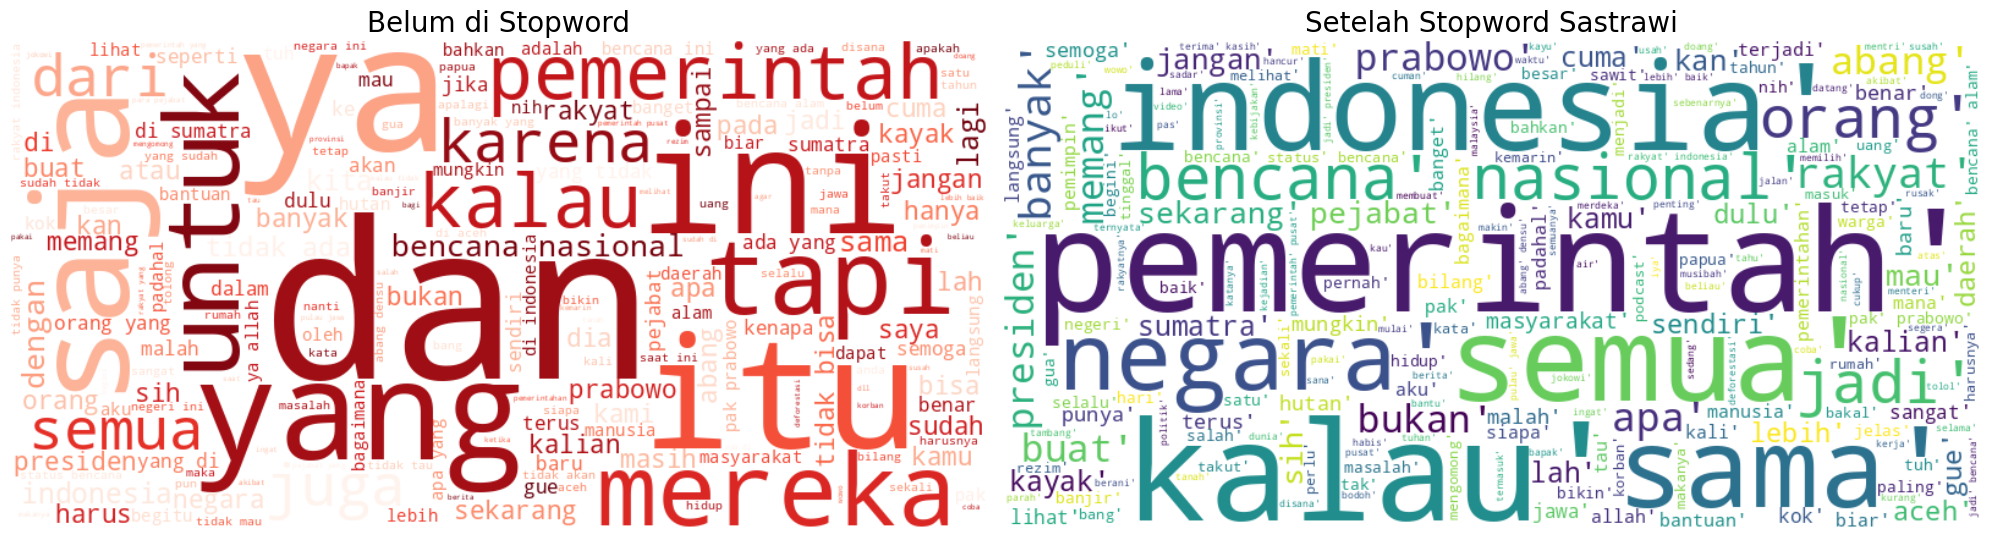

In [ ]:
# variable berisi wordcloud stopword
text_before = ' '.join(df['tokenize'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)))

# variable berisi wordcloud stopword + custom
text_after = ' '.join(df['stopword_before'].astype(str))

# tentukan parameter yang sama
wc_params = {'width': 800, 'height': 400, 'background_color': 'white'}

wc_before = WordCloud(**wc_params, colormap='Reds').generate(text_before)
wc_after = WordCloud(**wc_params, colormap='viridis').generate(text_after)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(wc_before, interpolation='bilinear')
ax[0].set_title('Belum di Stopword', fontsize=20);
ax[0].axis('off');

ax[1].imshow(wc_after, interpolation='bilinear')
ax[1].set_title('Setelah Stopword Sastrawi', fontsize=20);
ax[1].axis('off');

plt.tight_layout()
plt.show()

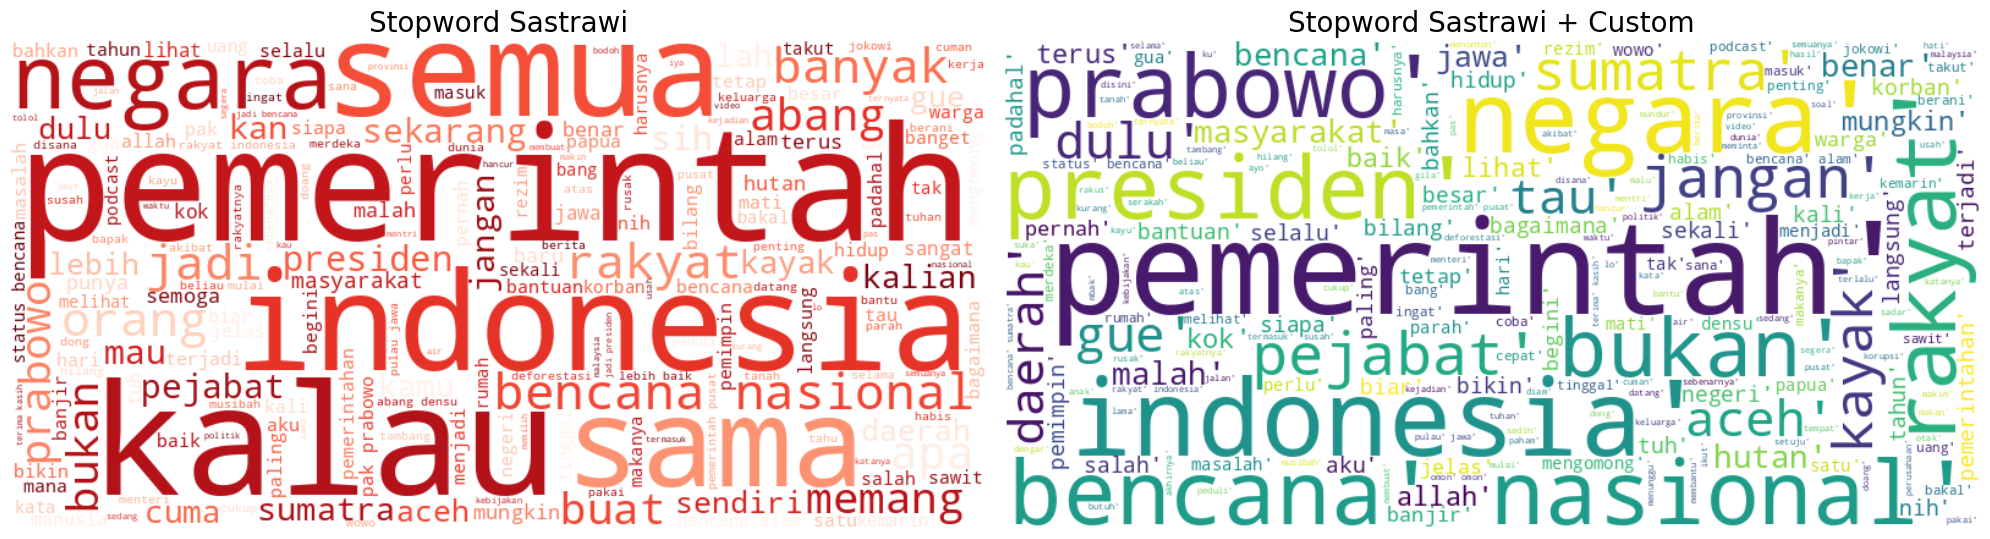

In [ ]:
# variable berisi wordcloud stopword
text_before = ' '.join(df['stopword_before'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)))

# variable berisi wordcloud stopword + custom
text_after = ' '.join(df['stopword_after'].astype(str))

# tentukan parameter yang sama
wc_params = {'width': 800, 'height': 400, 'background_color': 'white'}

wc_before = WordCloud(**wc_params, colormap='Reds').generate(text_before)
wc_after = WordCloud(**wc_params, colormap='viridis').generate(text_after)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(wc_before, interpolation='bilinear')
ax[0].set_title('Stopword Sastrawi', fontsize=20);
ax[0].axis('off');

ax[1].imshow(wc_after, interpolation='bilinear')
ax[1].set_title('Stopword Sastrawi + Custom', fontsize=20);
ax[1].axis('off');

plt.tight_layout()
plt.show()

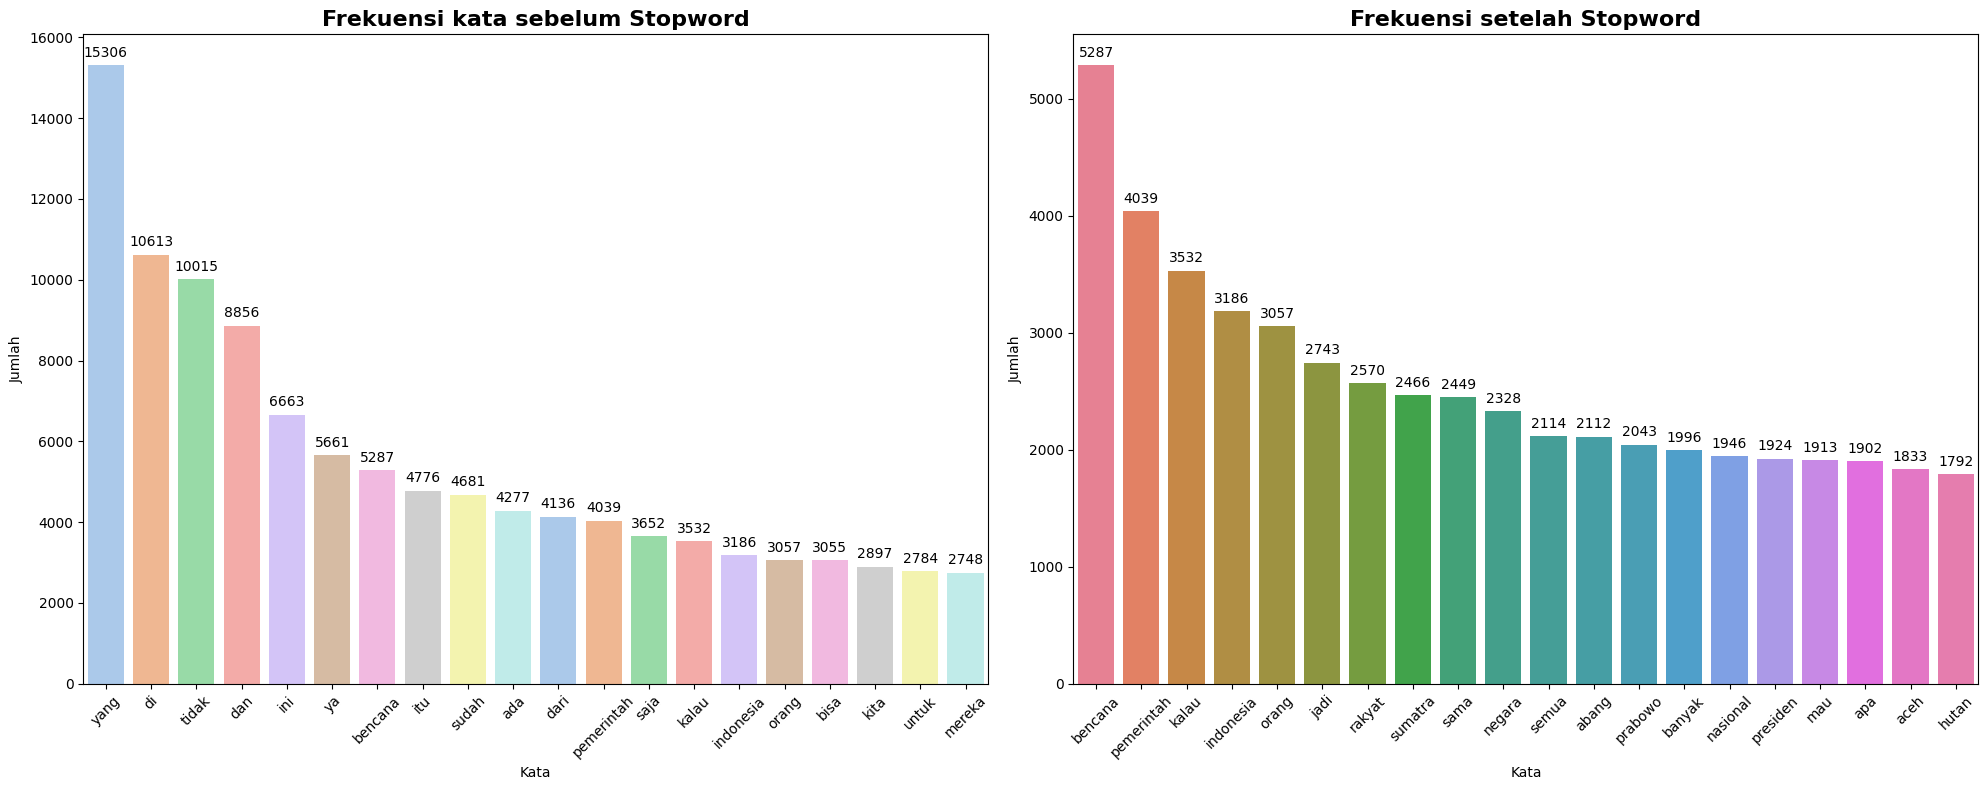

In [ ]:
def get_top_n_words(column_series, n=20):
    # kumpulkan semua kata dari list dalam kolom
    all_words = [word for sublist in column_series if isinstance(sublist, list) for word in sublist]
    word_freq = Counter(all_words)
    return pd.DataFrame(word_freq.most_common(n), columns=['Kata', 'Jumlah'])

# ambil data top 20
df_before = get_top_n_words(df['tokenize'], n=20)
df_after = get_top_n_words(df['stopword_before'], n=20)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# kiri stopword sastrawi
sns_before = sns.barplot(x='Kata', y='Jumlah', data=df_before, ax=ax[0], palette='pastel', hue='Kata', legend=False)
ax[0].set_title('Frekuensi kata sebelum Stopword', fontsize=16, fontweight='bold')
ax[0].tick_params(axis='x', rotation=45)
# kiri stopword sastrawi + custom
sns_after = sns.barplot(x='Kata', y='Jumlah', data=df_after, ax=ax[1], palette='husl', hue='Kata', legend=False)
ax[1].set_title('Frekuensi setelah Stopword', fontsize=16, fontweight='bold')
ax[1].tick_params(axis='x', rotation=45)

# satukan ke dalam list
charts = [sns_before, sns_after]

# loop setiap chart
for chart in charts:
    for p in chart.patches:
        chart.annotate(format(p.get_height(), '.0f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')

plt.tight_layout()
plt.show()

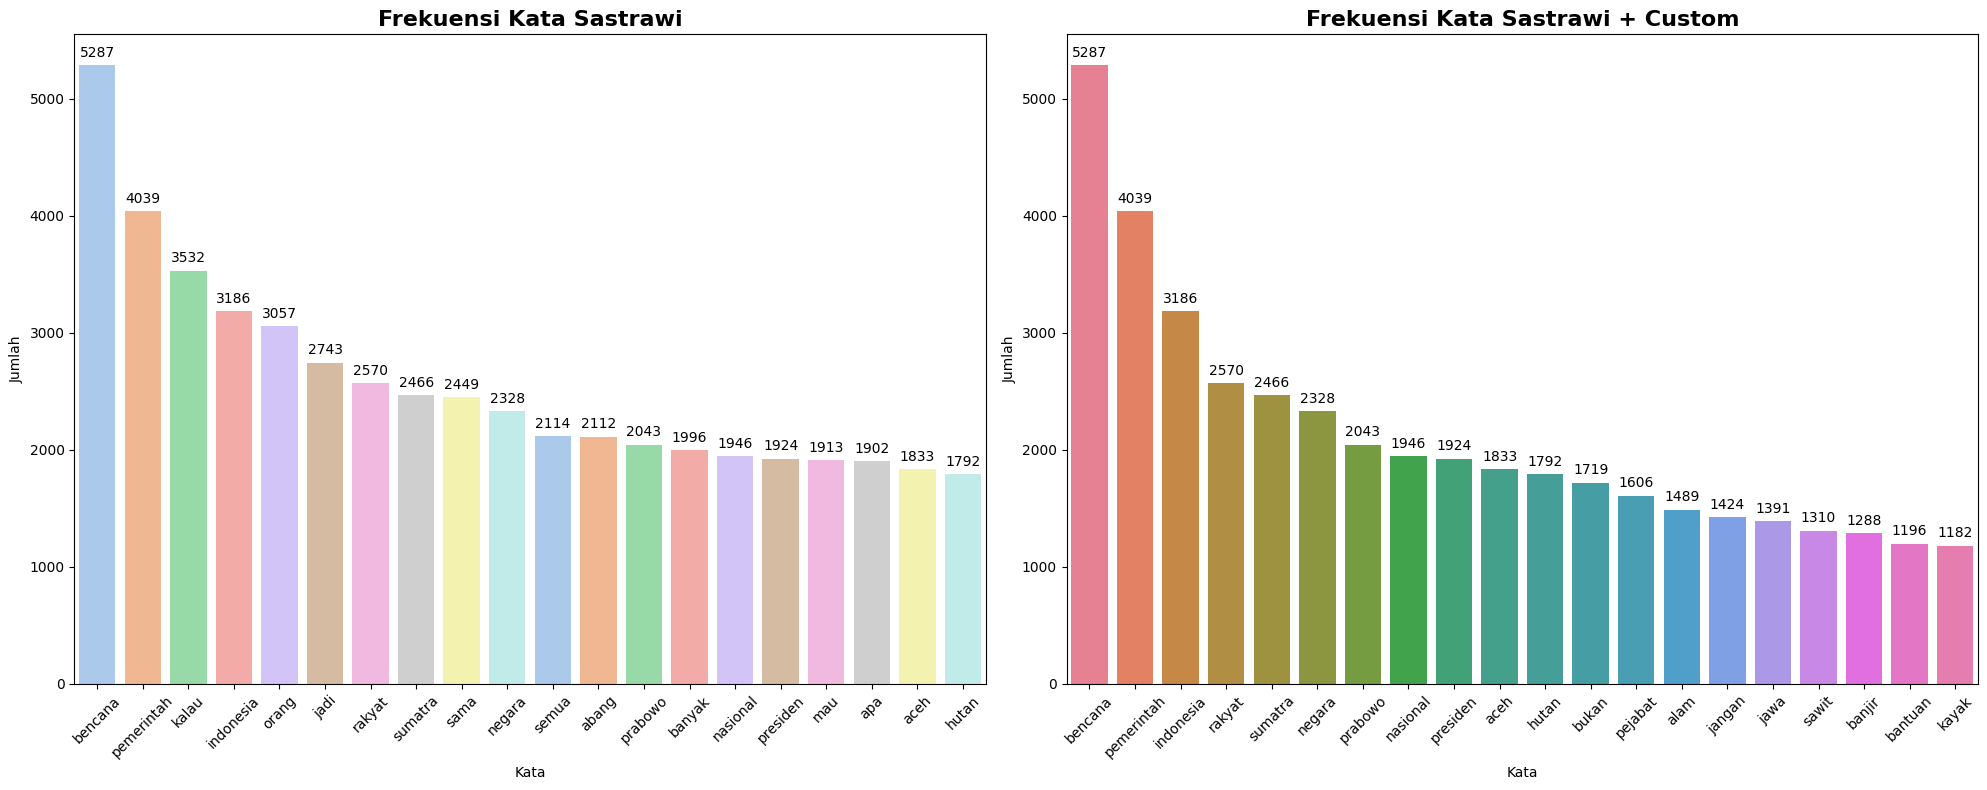

In [ ]:
def get_top_n_words(column_series, n=20):
    # kumpulkan semua kata dari list dalam kolom
    all_words = [word for sublist in column_series if isinstance(sublist, list) for word in sublist]
    word_freq = Counter(all_words)
    return pd.DataFrame(word_freq.most_common(n), columns=['Kata', 'Jumlah'])

# ambil data top 20
df_before = get_top_n_words(df['stopword_before'], n=20)
df_after = get_top_n_words(df['stopword_after'], n=20)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# kiri stopword sastrawi
sns_before = sns.barplot(x='Kata', y='Jumlah', data=df_before, ax=ax[0], palette='pastel', hue='Kata', legend=False)
ax[0].set_title('Frekuensi Kata Sastrawi', fontsize=16, fontweight='bold')
ax[0].tick_params(axis='x', rotation=45)
# kiri stopword sastrawi + custom
sns_after = sns.barplot(x='Kata', y='Jumlah', data=df_after, ax=ax[1], palette='husl', hue='Kata', legend=False)
ax[1].set_title('Frekuensi Kata Sastrawi + Custom', fontsize=16, fontweight='bold')
ax[1].tick_params(axis='x', rotation=45)

# satukan ke dalam list
charts = [sns_before, sns_after]

# loop setiap chart
for chart in charts:
    for p in chart.patches:
        chart.annotate(format(p.get_height(), '.0f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [ ]:
# lakukan stemming (balikan ke dasar kata)
# "suka", "menyukai", "disukai" = "suka"
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_text(text_list):
    if isinstance(text_list, list):
        # Sastrawi butuh input berupa string
        text_string = ' '.join(text_list)
        return stemmer.stem(text_string)
    return text_list

# terapkan stemming pada kolom stopword yang sudah clean
df['stemming'] = df['stopword_after'].apply(stemming_text)

df['tokenize_final'] = df['stemming'].apply(lambda x: x.split() if isinstance(x, str) else [])
df.head()

,channel,likes,comment,cleaning,case_folding,normalisasi,tokenize,stopword_before,stopword_after,stemming,tokenize_final
0,Ferry Irwandi,4K,Lekas pulih Bumi Andalasku!,Lekas pulih Bumi Andalasku,lekas pulih bumi andalasku,lekas pulih bumi andalasku,"[lekas, pulih, bumi, andalasku]","[lekas, pulih, bumi, andalasku]","[lekas, pulih, bumi, andalasku]",lekas pulih bumi andalas,"[lekas, pulih, bumi, andalas]"
1,Ferry Irwandi,0,Prabowo dari dulu jg punya lahan sawit d Sumat...,Prabowo dari dulu jg punya lahan sawit d Sumat...,prabowo dari dulu jg punya lahan sawit d sumat...,prabowo dari dulu juga punya lahan sawit di su...,"[prabowo, dari, dulu, juga, punya, lahan, sawi...","[prabowo, dulu, punya, lahan, sawit, sumatra, ...","[prabowo, dulu, lahan, sawit, sumatra, ratusan...",prabowo dulu lahan sawit sumatra ratus ribu he...,"[prabowo, dulu, lahan, sawit, sumatra, ratus, ..."
2,Ferry Irwandi,0,Lahir di Jambi asal payuhkumbuah,Lahir di Jambi asal payuhkumbuah,lahir di jambi asal payuhkumbuah,lahir di jambi asal payuhkumbuah,"[lahir, di, jambi, asal, payuhkumbuah]","[lahir, jambi, asal, payuhkumbuah]","[lahir, jambi, asal, payuhkumbuah]",lahir jambi asal payuhkumbuah,"[lahir, jambi, asal, payuhkumbuah]"
3,Ferry Irwandi,0,PROVOKATOR SESUNGGUHNYA,PROVOKATOR SESUNGGUHNYA,provokator sesungguhnya,provokator sesungguhnya,"[provokator, sesungguhnya]","[provokator, sesungguhnya]","[provokator, sesungguhnya]",provokator sungguh,"[provokator, sungguh]"
4,Ferry Irwandi,0,"Menurut aku ya,..Kok lebih pinter bg feri Irwa...",Menurut aku yaKok lebih pinter bg feri Irwandi...,menurut aku yakok lebih pinter bg feri irwandi...,menurut aku yakok lebih pintar bang feri irwan...,"[menurut, aku, yakok, lebih, pintar, bang, fer...","[aku, yakok, lebih, pintar, bang, feri, irwand...","[aku, yakok, pintar, bang, feri, irwandi, diba...",aku yakok pintar bang feri irwandi banding tri...,"[aku, yakok, pintar, bang, feri, irwandi, band..."


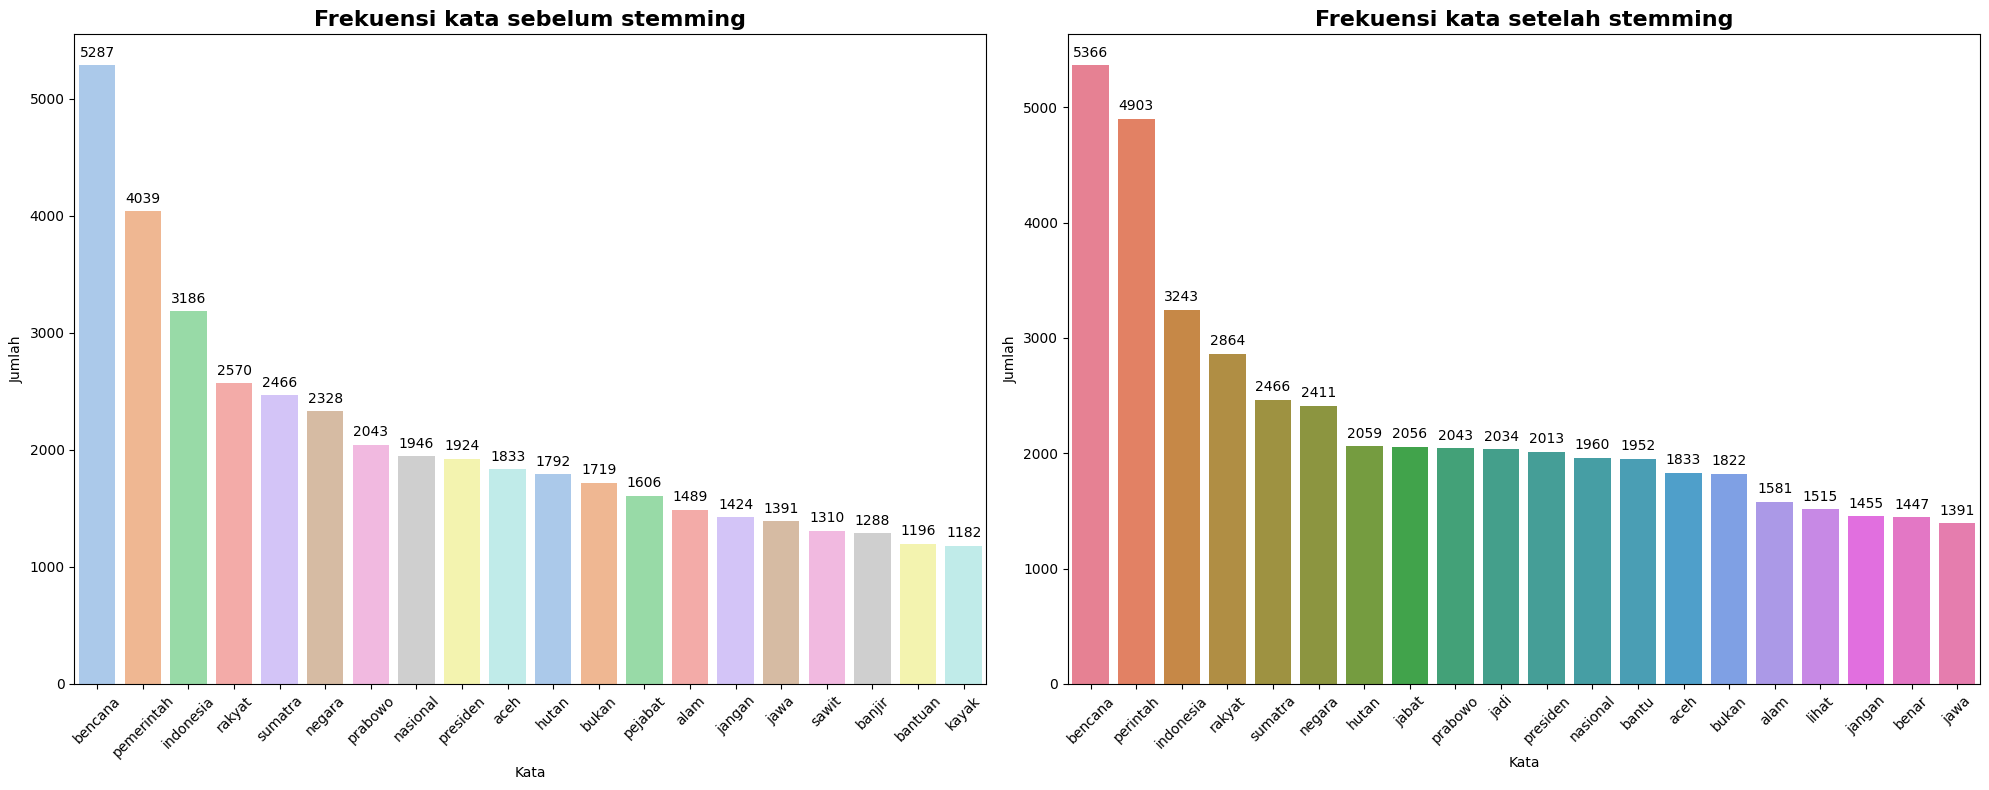

In [ ]:
def get_top_n_words(column_series, n=20):
    # kumpulkan semua kata dari list dalam kolom
    all_words = [word for sublist in column_series if isinstance(sublist, list) for word in sublist]
    word_freq = Counter(all_words)
    return pd.DataFrame(word_freq.most_common(n), columns=['Kata', 'Jumlah'])

# ambil data top 20
df_before = get_top_n_words(df['stopword_after'], n=20)
df_after = get_top_n_words(df['tokenize_final'], n=20)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# kiri sebelum stemmming
sns_before = sns.barplot(x='Kata', y='Jumlah', data=df_before, ax=ax[0], palette='pastel', hue='Kata', legend=False)
ax[0].set_title('Frekuensi kata sebelum stemming', fontsize=16, fontweight='bold')
ax[0].tick_params(axis='x', rotation=45)
# kanan setelah stemming
sns_after = sns.barplot(x='Kata', y='Jumlah', data=df_after, ax=ax[1], palette='husl', hue='Kata', legend=False)
ax[1].set_title('Frekuensi kata setelah stemming', fontsize=16, fontweight='bold')
ax[1].tick_params(axis='x', rotation=45)

# satukan ke dalam list
charts = [sns_before, sns_after]

# loop setiap chart
for chart in charts:
    for p in chart.patches:
        chart.annotate(format(p.get_height(), '.0f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [ ]:
df.to_csv('hasil_preprocessing_data_new.csv', encoding='utf8', index=False)

## Labeling

In [ ]:
data = pd.read_csv('hasil_preprocessing_data_new.csv')
data.head()

In [ ]:
# ambil kolom stemming dan stopword
df = data[['stopword_after', 'stemming']].copy()
df.head()

,stopword_after,stemming
0,"['lekas', 'pulih', 'bumi', 'andalasku']",lekas pulih bumi andalas
1,"['prabowo', 'dulu', 'lahan', 'sawit', 'sumatra...",prabowo dulu lahan sawit sumatra ratus ribu he...
2,"['lahir', 'jambi', 'asal', 'payuhkumbuah']",lahir jambi asal payuhkumbuah
3,"['provokator', 'sesungguhnya']",provokator sungguh
4,"['aku', 'yakok', 'pintar', 'bang', 'feri', 'ir...",aku yakok pintar bang feri irwandi banding tri...


In [ ]:
df['stemming'].duplicated().sum()

np.int64(610)

In [ ]:
# hapus komentar duplikat
df.drop_duplicates(subset=['stemming'], keep='first', inplace=True)
df['stemming'].duplicated().sum()

np.int64(0)

In [ ]:
# Load model IndoRoBERTa
pretrained_name = "w11wo/indonesian-roberta-base-sentiment-classifier"

# Buat pipeline dan masukan ke variable
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    device=0  # pakai GPU kalo ada
)

# Potong teks menjadi bagian kecil maksimal 512 karakter per token (batas model indobert)
def chunk_text(text, max_len=512):
    # Membagi teks menjadi beberapa potongan agar tidak melebihi batas model
    return [text[i:i+max_len] for i in range(0, len(text), max_len)]

# Modifikasi fungsi robust_sentiment dengan teknik Averaging/Voting
def robust_sentiment(text):
    if not isinstance(text, str) or not text.strip():
        return {"label": "neutral", "score": 0.0}

    try:
        # Jika teks panjang, potong menjadi beberapa bagian
        chunks = chunk_text(text)

        # Jalankan prediksi untuk setiap potongan teks
        results = [sentiment_pipeline(chunk)[0] for chunk in chunks]

        # Ambil semua label dan skor dari hasil potongan
        labels = [r["label"] for r in results]
        scores = [r["score"] for r in results]

        # Tentukan label final berdasarkan yang paling sering muncul
        final_label = max(set(labels), key=labels.count)
        # Hitung rata-rata skor keyakinan model
        final_score = sum(scores) / len(scores)

        return {"label": final_label, "score": final_score}

    except Exception as e:
        print(f"Error pada teks: {text[:100]}... Error: {e}")
        return {"label": "error", "score": 0.0}

# Progres bar
tqdm.pandas()

# Pakai progress_apply untuk melihat perkiraan waktu selesai
results = df["stemming"].progress_apply(robust_sentiment)

df = df.copy()

# Pecah hasil menjadi kolom Label dan Score
df["Sentiment Label"] = results.apply(lambda x: x["label"])
df["Sentiment Score"] = results.apply(lambda x: x["score"])

In [ ]:
df.head(10)

,stopword_after,stemming,Sentiment Label,Sentiment Score
0,"['lekas', 'pulih', 'bumi', 'andalasku']",lekas pulih bumi andalas,neutral,0.774940
1,"['prabowo', 'dulu', 'lahan', 'sawit', 'sumatra...",prabowo dulu lahan sawit sumatra ratus ribu he...,neutral,0.947467
2,"['lahir', 'jambi', 'asal', 'payuhkumbuah']",lahir jambi asal payuhkumbuah,neutral,0.998261
3,"['provokator', 'sesungguhnya']",provokator sungguh,negative,0.741040
4,"['aku', 'yakok', 'pintar', 'bang', 'feri', 'ir...",aku yakok pintar bang feri irwandi banding tri...,neutral,0.636395
5,"['biar', 'pintar', 'baca', 'bencana', 'nasiona...",biar pintar baca bencana nasional indonesia at...,neutral,0.998663
6,"['seseorang', 'pernah', 'berkata', 'jangan', '...",orang pernah kata jangan takut deforestasi lihat,negative,0.944519
7,"['hidup', 'bowo', 'hidup', 'bahlil', 'hidup', ...",hidup bowo hidup bahlil hidup dpr rompi anti p...,neutral,0.999009
8,"['ferryjadikan', 'keadaan', 'susah', 'acheh', ...",ferryjadikan ada susah acheh jadi senangjadika...,positive,0.616686
9,"['dibangun', 'bendungan', 'era', 'jaokowi', 'p...",bangun bendung era jaokowi paling bangun bendu...,neutral,0.965518


In [ ]:
mapping = {
    'positive': 'positif',
    'neutral': 'netral',
    'negative': 'negatif'
}

df['Sentiment Label'] = df['Sentiment Label'].map(mapping)
df.head(10)

,stopword_after,stemming,Sentiment Label,Sentiment Score
0,"['lekas', 'pulih', 'bumi', 'andalasku']",lekas pulih bumi andalas,netral,0.774940
1,"['prabowo', 'dulu', 'lahan', 'sawit', 'sumatra...",prabowo dulu lahan sawit sumatra ratus ribu he...,netral,0.947467
2,"['lahir', 'jambi', 'asal', 'payuhkumbuah']",lahir jambi asal payuhkumbuah,netral,0.998261
3,"['provokator', 'sesungguhnya']",provokator sungguh,negatif,0.741040
4,"['aku', 'yakok', 'pintar', 'bang', 'feri', 'ir...",aku yakok pintar bang feri irwandi banding tri...,netral,0.636395
5,"['biar', 'pintar', 'baca', 'bencana', 'nasiona...",biar pintar baca bencana nasional indonesia at...,netral,0.998663
6,"['seseorang', 'pernah', 'berkata', 'jangan', '...",orang pernah kata jangan takut deforestasi lihat,negatif,0.944519
7,"['hidup', 'bowo', 'hidup', 'bahlil', 'hidup', ...",hidup bowo hidup bahlil hidup dpr rompi anti p...,netral,0.999009
8,"['ferryjadikan', 'keadaan', 'susah', 'acheh', ...",ferryjadikan ada susah acheh jadi senangjadika...,positif,0.616686
9,"['dibangun', 'bendungan', 'era', 'jaokowi', 'p...",bangun bendung era jaokowi paling bangun bendu...,netral,0.965518


In [ ]:
df = df.copy()

df['channel'] = data['channel']
df['likes'] = data['likes']

df.head(10)

,stopword_after,stemming,Sentiment Label,Sentiment Score,channel,likes
0,"['lekas', 'pulih', 'bumi', 'andalasku']",lekas pulih bumi andalas,netral,0.774940,Ferry Irwandi,4K
1,"['prabowo', 'dulu', 'lahan', 'sawit', 'sumatra...",prabowo dulu lahan sawit sumatra ratus ribu he...,netral,0.947467,Ferry Irwandi,0
2,"['lahir', 'jambi', 'asal', 'payuhkumbuah']",lahir jambi asal payuhkumbuah,netral,0.998261,Ferry Irwandi,0
3,"['provokator', 'sesungguhnya']",provokator sungguh,negatif,0.741040,Ferry Irwandi,0
4,"['aku', 'yakok', 'pintar', 'bang', 'feri', 'ir...",aku yakok pintar bang feri irwandi banding tri...,netral,0.636395,Ferry Irwandi,0
5,"['biar', 'pintar', 'baca', 'bencana', 'nasiona...",biar pintar baca bencana nasional indonesia at...,netral,0.998663,Ferry Irwandi,0
6,"['seseorang', 'pernah', 'berkata', 'jangan', '...",orang pernah kata jangan takut deforestasi lihat,negatif,0.944519,Ferry Irwandi,1
7,"['hidup', 'bowo', 'hidup', 'bahlil', 'hidup', ...",hidup bowo hidup bahlil hidup dpr rompi anti p...,netral,0.999009,Ferry Irwandi,0
8,"['ferryjadikan', 'keadaan', 'susah', 'acheh', ...",ferryjadikan ada susah acheh jadi senangjadika...,positif,0.616686,Ferry Irwandi,0
9,"['dibangun', 'bendungan', 'era', 'jaokowi', 'p...",bangun bendung era jaokowi paling bangun bendu...,netral,0.965518,Ferry Irwandi,0


In [ ]:
# Setelah digabung, baru di simpan
df.to_csv('hasil_akhir_sentimen_lengkap_new_before_stemming.csv', index=False)

## Exploratory Data Analysis (EDA)

In [3]:
df = pd.read_csv('hasil_akhir_sentimen_lengkap_new_stemming.csv')
df

,stopword_after,stemming,Sentiment Label,Sentiment Score,channel,likes
0,"['lekas', 'pulih', 'bumi', 'andalasku']",lekas pulih bumi andalas,netral,0.774940,Ferry Irwandi,4K
1,"['prabowo', 'dulu', 'lahan', 'sawit', 'sumatra...",prabowo dulu lahan sawit sumatra ratus ribu he...,netral,0.947467,Ferry Irwandi,0
2,"['lahir', 'jambi', 'asal', 'payuhkumbuah']",lahir jambi asal payuhkumbuah,netral,0.998261,Ferry Irwandi,0
3,"['provokator', 'sesungguhnya']",provokator sungguh,negatif,0.741040,Ferry Irwandi,0
4,"['aku', 'yakok', 'pintar', 'bang', 'feri', 'ir...",aku yakok pintar bang feri irwandi banding tri...,netral,0.636395,Ferry Irwandi,0
...,...,...,...,...,...,...
25478,"['makanya', 'belajar']",makanya ajar,positif,0.995763,Sepulang Sekolah,1
25479,"['tenang', 'pertalite']",tenang pertalite,negatif,0.688481,Sepulang Sekolah,0
25480,"['at', 'least', 'perbaiki', 'bawah']",at least baik bawah,positif,0.847452,Sepulang Sekolah,0
25481,"['lung', 'tuh']",lung tuh,positif,0.793583,Sepulang Sekolah,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25483 entries, 0 to 25482
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stopword_after   25483 non-null  object 
 1   stemming         25482 non-null  object 
 2   Sentiment Label  25483 non-null  object 
 3   Sentiment Score  25483 non-null  float64
 4   channel          25483 non-null  object 
 5   likes            25483 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.2+ MB


In [5]:
# Ambil data yang probabilitas tertingginya kecil (model ragu)
ragu_df = df[df['Sentiment Score'] < 0.6]
ragu_df[['stemming', 'Sentiment Label', 'Sentiment Score']].head(10)

,stemming,Sentiment Label,Sentiment Score
34,mayoritas nu bicara dapat benar nu masalah int...,netral,0.510208
85,perintah banyak wacana nggedabrus,negatif,0.597125
116,muliate suara,positif,0.496379
133,amin rabb,negatif,0.482690
142,prediksi bakal bencana kayak begini lama predi...,netral,0.538215
163,mirip kayak filem luar america buat,netral,0.467002
164,turut duka atas korban tinggal segera pulih se...,netral,0.574053
166,sumatra tepat tapanuli selatan bagaimana pulih...,netral,0.544936
172,gera andalas merdeka,netral,0.583345
173,aku jawa aku dulu suka dinas luar sumatra turu...,netral,0.463369


In [6]:
ragu_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1207 entries, 34 to 25454
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stopword_after   1207 non-null   object 
 1   stemming         1206 non-null   object 
 2   Sentiment Label  1207 non-null   object 
 3   Sentiment Score  1207 non-null   float64
 4   channel          1207 non-null   object 
 5   likes            1207 non-null   object 
dtypes: float64(1), object(5)
memory usage: 66.0+ KB


In [7]:
# Hanya ambil yang Sentimen Score-nya >= 0.6 (60%)
# Ini memastikan kita hanya menggunakan data yang labelnya dianggap akurat oleh model
df_clean = df[df['Sentiment Score'] >= 0.6].copy()

# Cek perbandingan jumlah data sebelum dan sesudah difilter
print(f"Jumlah data awal: {len(df)}")
print(f"Jumlah data setelah filter: {len(df_clean)}")
print(f"Data yang dibuang: {len(df) - len(df_clean)}")

# Cek sebaran label setelah pembersihan
print("\nSebaran Label Setelah Filter:")
df_clean['Sentiment Label'].value_counts()

Jumlah data awal: 25483
Jumlah data setelah filter: 24276
Data yang dibuang: 1207

Sebaran Label Setelah Filter:


,count
Sentiment Label,
negatif,13124
netral,7368
positif,3784


In [8]:
df = df_clean.copy()

In [9]:
df['stemming'].isnull().sum()

np.int64(0)

In [10]:
df['stemming'].duplicated().sum()

np.int64(0)

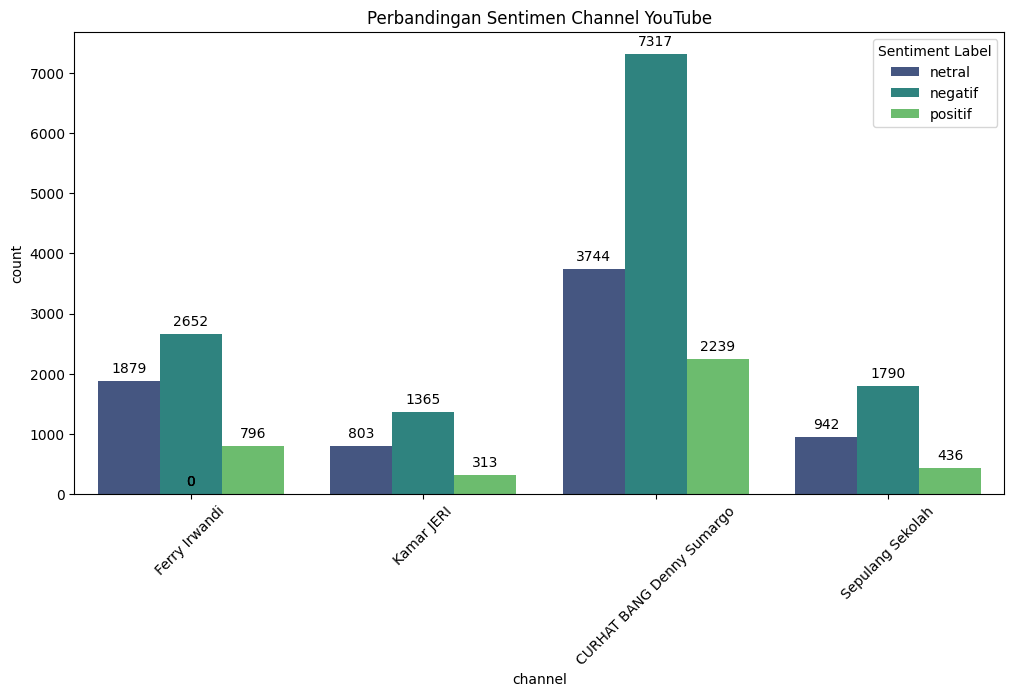

In [11]:
# visualisasi perbandingan sentimen menggunakan Bar Chart
plt.figure(figsize=(12, 6))
sns_plot = sns.countplot(data=df, x='channel', hue='Sentiment Label', palette='viridis')
plt.title('Perbandingan Sentimen Channel YouTube')
plt.xticks(rotation=45)

# tampilkan angka di atas setiap bar
for p in sns_plot.patches:
    sns_plot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.show()

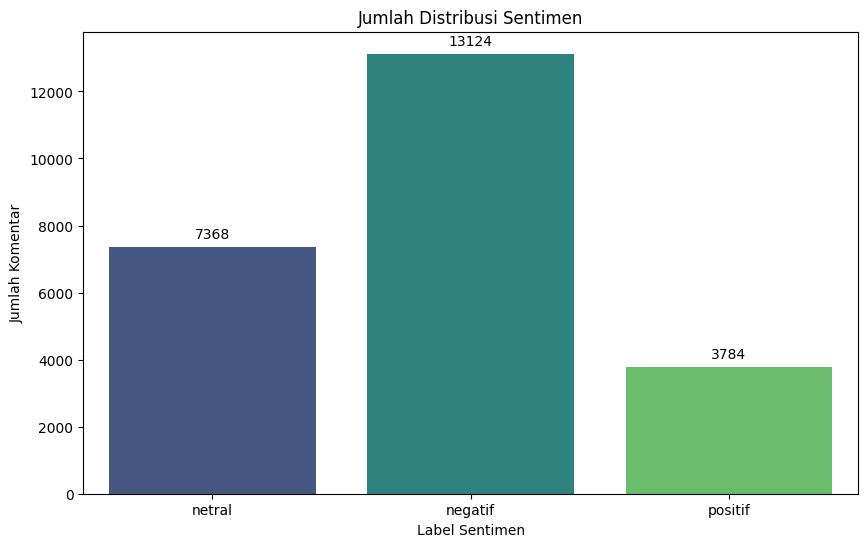

In [12]:
# visualisasi Bar Chart
plt.figure(figsize=(10, 6))
sns_plot = sns.countplot(x='Sentiment Label', data=df, palette='viridis', hue='Sentiment Label', legend=False)
plt.title('Jumlah Distribusi Sentimen')
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah Komentar')

# tampilkan angka di atas setiap bar
for p in sns_plot.patches:
    sns_plot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.show()

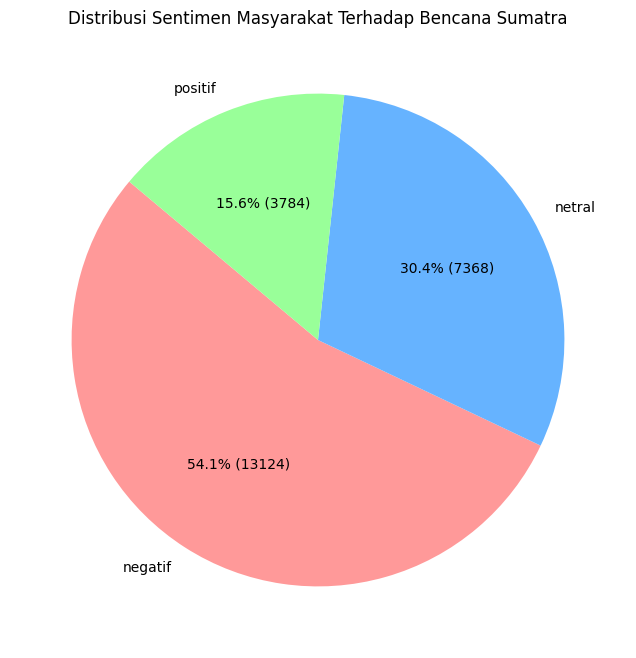

In [13]:
# hitung jumlah masing masing sentimen dan simpan ke variable
sentiment_counts = df['Sentiment Label'].value_counts()

# fungsi untuk menampilkan angka real dan persentase
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}% ({:d})'.format(pct, val)
    return my_format

# visualisasi Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct=autopct_format(sentiment_counts), startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribusi Sentimen Masyarakat Terhadap Bencana Sumatra')
plt.show()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24276 entries, 0 to 25482
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stopword_after   24276 non-null  object 
 1   stemming         24276 non-null  object 
 2   Sentiment Label  24276 non-null  object 
 3   Sentiment Score  24276 non-null  float64
 4   channel          24276 non-null  object 
 5   likes            24276 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.3+ MB


In [15]:
def convert_likes(likes):
    if isinstance(likes, str):
        # ubah koma jadi titik jika ada
        likes = likes.upper().replace(',', '.')
        if 'K' in likes:
            return float(likes.replace('K', '')) * 1000
        elif 'M' in likes:
            return float(likes.replace('M', '')) * 1000000

    try:
        return float(likes)
    except:
        return 0.0

# terapkan fungsi pada kolom likes
df['likes'] = df['likes'].apply(convert_likes).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24276 entries, 0 to 25482
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stopword_after   24276 non-null  object 
 1   stemming         24276 non-null  object 
 2   Sentiment Label  24276 non-null  object 
 3   Sentiment Score  24276 non-null  float64
 4   channel          24276 non-null  object 
 5   likes            24276 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 1.3+ MB


In [16]:
# Menampilkan statistik jumlah komentar dan rata-rata likes per sentimen
stats = df.groupby('Sentiment Label').agg({
    'stopword_after': 'count',
    'likes': ['mean', 'sum']
}).rename(columns={'count': 'Jumlah Komentar', 'mean': 'Rata-rata Likes', 'sum': 'Total Likes'})

stats

stopword_after           likes            
                Jumlah Komentar Rata-rata Likes Total Likes
Sentiment Label                                            
negatif                   13124        3.997638       52465
netral                     7368        6.481270       47754
positif                    3784        3.927854       14863

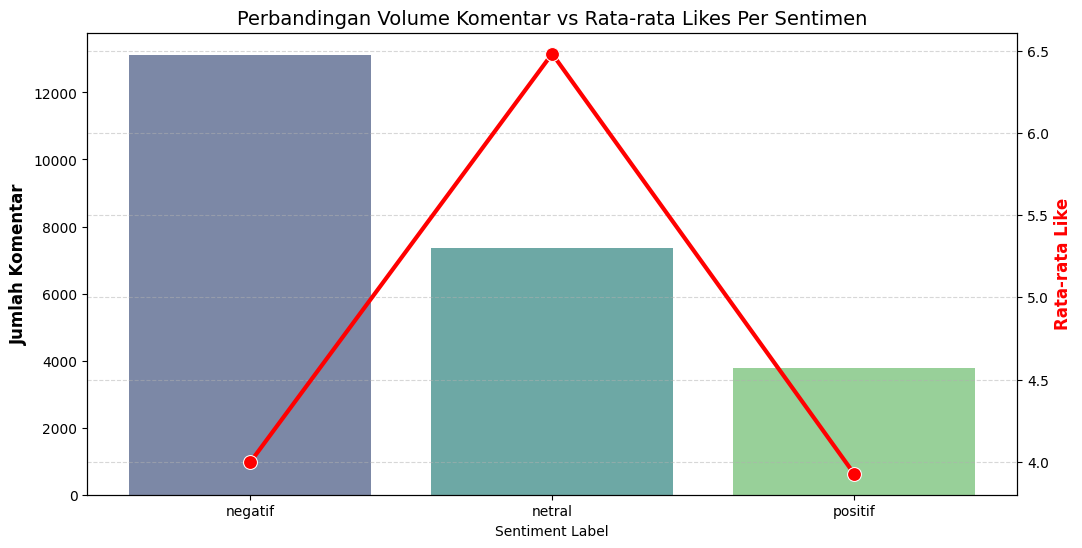

In [17]:
# Siapkan data dan reset index
data = stats.copy()
data.columns = ['Jumlah Komentar', 'Rata-rata Likes', 'Total Likes']
data = data.reset_index()

# Buat plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Batang untuk Jumlah Komentar
sns.barplot(x='Sentiment Label', y='Jumlah Komentar', data=data, ax=ax1, palette='viridis', alpha=0.7, hue='Sentiment Label', legend=False)
ax1.set_ylabel('Jumlah Komentar', fontsize=12, fontweight='bold')
ax1.set_title('Perbandingan Volume Komentar vs Rata-rata Likes Per Sentimen', fontsize=14)

# Plot Garis untuk Rata-rata Likes (Sumbu Y Kedua)
ax2 = ax1.twinx()
sns.lineplot(x='Sentiment Label', y='Rata-rata Likes', data=data, ax=ax2, marker='o', color='red', linewidth=3, markersize=10)
ax2.set_ylabel('Rata-rata Like', fontsize=12, fontweight='bold', color='red')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

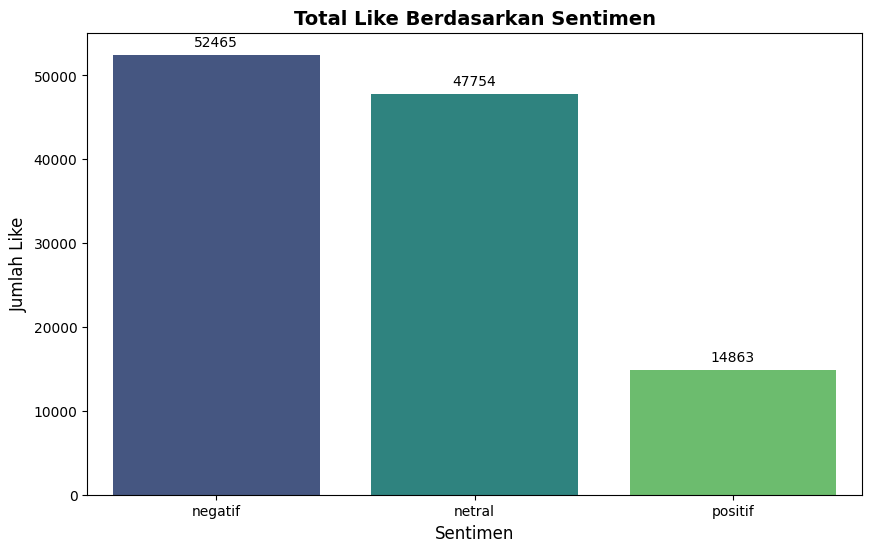

In [18]:
# Menghitung total likes yang didapat oleh masing-masing sentimen
likes_per_sentiment = df.groupby('Sentiment Label')['likes'].sum().sort_values(ascending=False)

# Visualisasi dengan Seaborn
plt.figure(figsize=(10, 6))
sns_plot = sns.barplot(x=likes_per_sentiment.index, y=likes_per_sentiment.values, palette='viridis', hue=likes_per_sentiment.index, legend=False)
plt.title('Total Like Berdasarkan Sentimen', fontsize=14, fontweight='bold')
plt.ylabel('Jumlah Like', fontsize=12)
plt.xlabel('Sentimen', fontsize=12)

# Tampilkan angka di atas setiap bar
for p in sns_plot.patches:
    sns_plot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.show()

In [19]:
# urutkan berdasarkan likes terbanyak
top_global = df.sort_values(by='likes', ascending=False).head(20)

# tampilkan 4 kolom kolom
print("20 komentar dengan like terbanyak secara keseluruhan")
display(top_global[['channel', 'likes', 'Sentiment Label', 'stemming']].reset_index(drop=True))

20 komentar dengan like terbanyak secara keseluruhan


,channel,likes,Sentiment Label,stemming
0,CURHAT BANG Denny Sumargo,9900,netral,dedy corbuzier berani ngangkat bencana sumatra...
1,CURHAT BANG Denny Sumargo,5400,netral,warga aceh tamiang ungsi mesjid nurul iman kam...
2,CURHAT BANG Denny Sumargo,4300,positif,gila trio takut bicara rezim mantap
3,CURHAT BANG Denny Sumargo,4100,negatif,sumatra kelar eh rusak papua lagibener stupidn...
4,Ferry Irwandi,4000,netral,lekas pulih bumi andalas
5,Ferry Irwandi,3300,negatif,lihat sumaterasaya lihat indonesia hancur jaha...
6,CURHAT BANG Denny Sumargo,2600,negatif,mending mbak stopppp buget alih korban gue ihlass
7,Ferry Irwandi,2100,netral,indonesia negara politik dapat ilmiah pernah d...
8,CURHAT BANG Denny Sumargo,2100,netral,prabowo the king of omon omon
9,Sepulang Sekolah,2100,negatif,tamak segilintir babi gerogot bumi


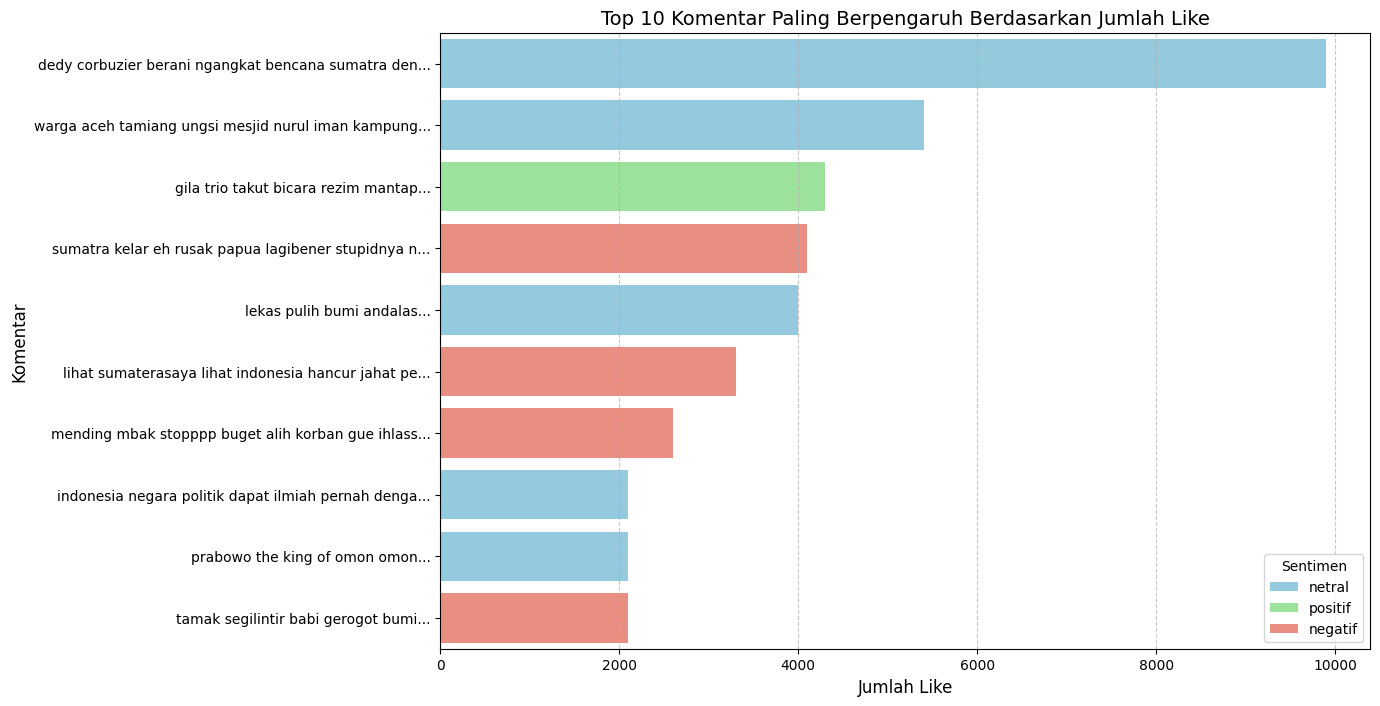

In [20]:
# ambil data 10 teratas
top_10_visual = top_global.head(10).copy()

# mempersingkat teks komentar untuk label grafik dengan cara ambil 50 karakter pertama saja
top_10_visual['short_comment'] = top_10_visual['stemming'].str.slice(0, 50) + "..."

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_10_visual,
    x='likes',
    y='short_comment',
    hue='Sentiment Label',
    palette={'netral': 'skyblue', 'negatif': 'salmon', 'positif': 'lightgreen'}
)

plt.title('Top 10 Komentar Paling Berpengaruh Berdasarkan Jumlah Like', fontsize=14)
plt.xlabel('Jumlah Like', fontsize=12)
plt.ylabel('Komentar', fontsize=12)
plt.legend(title='Sentimen')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

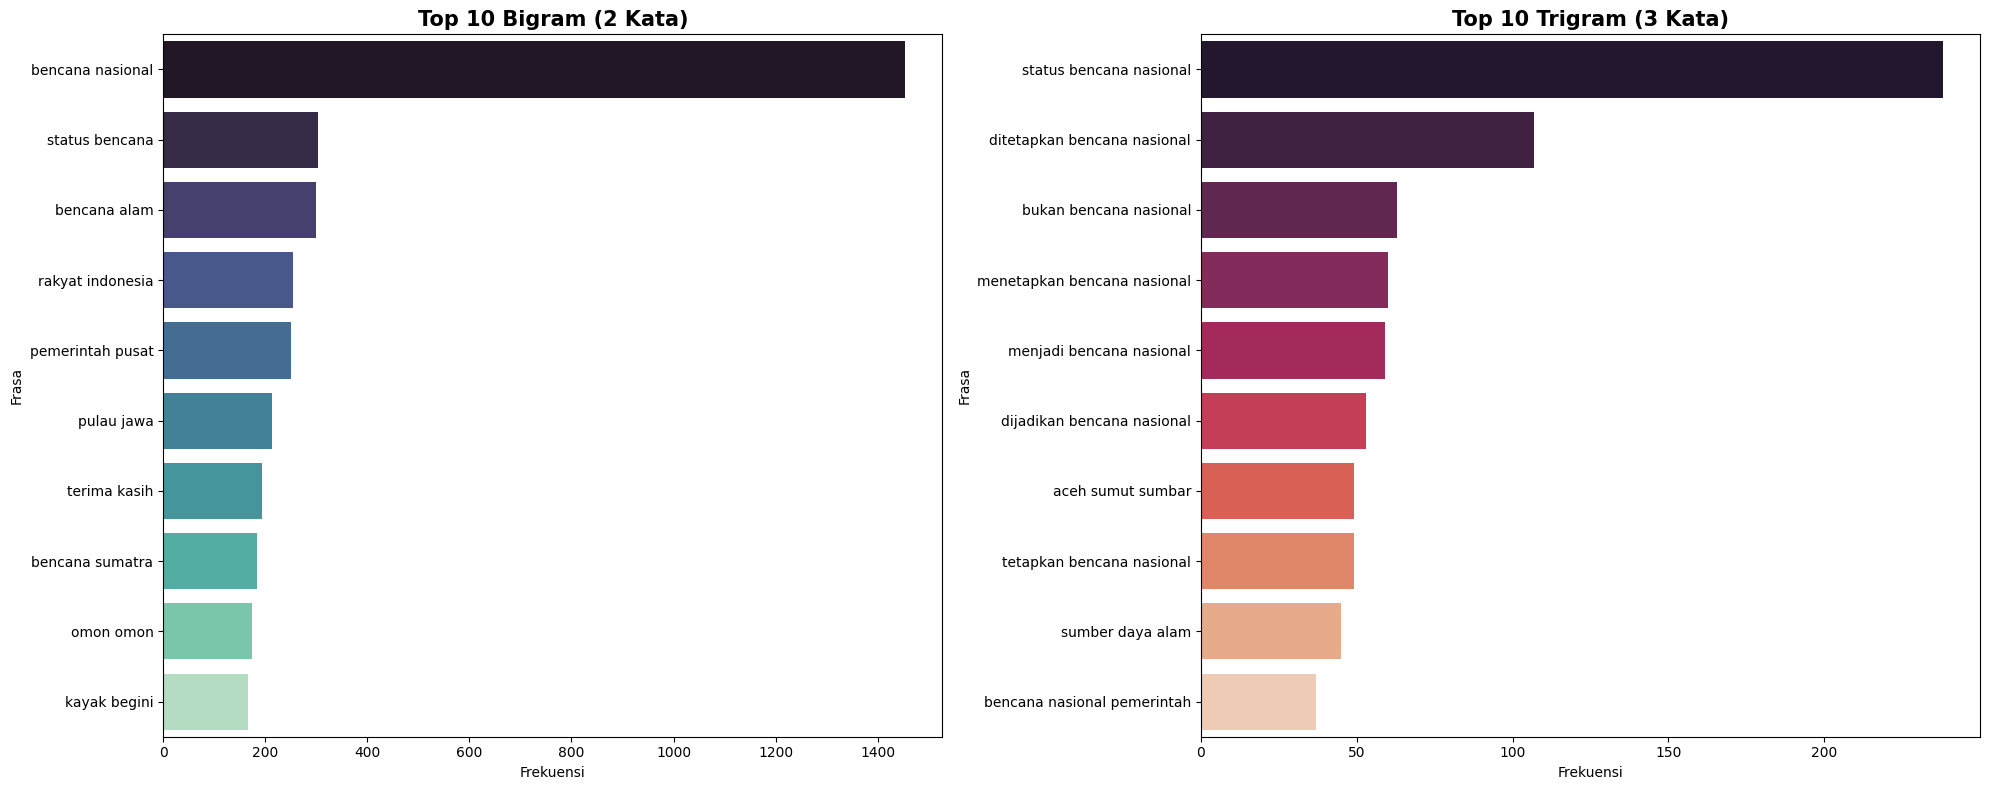

In [21]:
def plot_ngram(corpus, n=2, title='Top N-gram', color='viridis'):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)

    # hitung frekuensi
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

    # buat DataFrame untuk 10 teratas
    df_ngram = pd.DataFrame(words_freq[:10], columns=['Frasa', 'Jumlah'])

    # visualisasi
    sns.barplot(x='Jumlah', y='Frasa', hue='Frasa', data=df_ngram, palette=color, legend=False)
    plt.title(title, fontsize=15, fontweight='bold')
    plt.xlabel('Frekuensi')

# Mengambil data dari kolom yang teksnya masih utuh (bukan stemming)
data_teks = df['stopword_after'].astype(str)

plt.figure(figsize=(20, 8))

# Plot Bigram (2 Kata)
plt.subplot(1, 2, 1)
plot_ngram(data_teks, n=2, title='Top 10 Bigram (2 Kata)', color='mako')

# Plot Trigram (3 Kata)
plt.subplot(1, 2, 2)
plot_ngram(data_teks, n=3, title='Top 10 Trigram (3 Kata)', color='rocket')

plt.tight_layout()
plt.show()

In [22]:
df['Sentiment Label'].value_counts()

,count
Sentiment Label,
negatif,13124
netral,7368
positif,3784


In [23]:
# Mengambil sampel data agar seimbang (Downsampling)
df_neg = df[df['Sentiment Label'] == 'negatif'].sample(3784, random_state=42)
df_net = df[df['Sentiment Label'] == 'netral'].sample(3784, random_state=42)
df_pos = df[df['Sentiment Label'] == 'positif']

# Menggabungkan kembali
df_balanced = pd.concat([df_neg, df_net, df_pos])
df_balanced['Sentiment Label'].value_counts()

,count
Sentiment Label,
negatif,3784
netral,3784
positif,3784


In [24]:
df = df_balanced.copy()

In [25]:
df['stemming'].duplicated().sum()

np.int64(0)

In [26]:
df['stemming'].isnull().sum()

np.int64(0)

## Training

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
import pickle

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, SpatialDropout1D, GRU
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

### LSTM (Long Short-Term Memory)

In [28]:
# Letakan di fungsi encoder ke variable
le = LabelEncoder()

# Split Data (80% Latih, 20% Uji)
X = df['stemming'].astype(str).values
y = le.fit_transform(df['Sentiment Label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenisasi (Mengubah kata jadi angka indeks)
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding (Menyamakan panjang kalimat)
max_len = 50
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

print('Jumlah data latih:', X_train.shape)
print('Jumlah data test:', X_test.shape)

Jumlah data latih: (9081,)
Jumlah data test: (2271,)


In [29]:
vocab_size = len(tokenizer.word_index) + 1

# monitor='val_loss': Memantau error pada data validasi
# patience=3: Jika selama 3 epoch tidak ada perbaikan, training berhenti
# restore_best_weights=True: Mengambil bobot terbaik, bukan bobot terakhir saat berhenti
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_lstm = Sequential([
    # Dimensi 128 membantu menangkap konteks bahasa Indonesia yang kompleks
    Embedding(input_dim=vocab_size, output_dim=128),

    # Layer 1: Menangkap pola urutan kata secara mendalam (Bidirectional)
    Bidirectional(LSTM(128, return_sequences=True)),

    # Layer 2: Fokus pada fitur paling penting untuk klasifikasi sentimen
    Bidirectional(LSTM(64)),

    # Fully Connected Layer untuk mengolah hasil ekstraksi fitur
    Dense(64, activation='relu'),

    # Dropout 0.5 sangat penting untuk mencegah model_lstm sekadar menghafal (overfitting)
    Dropout(0.5),

    # Output 3 kelas (Negatif, Netral, Positif) dengan activation Softmax
    Dense(3, activation='softmax')
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Memulai Training Model dengan Early Stopping...")
history = model_lstm.fit(
    X_train_padded,
    y_train,
    epochs=100,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stop],
    verbose=1
)

Memulai Training Model dengan Early Stopping...
Epoch 1/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.4640 - loss: 1.0247 - val_accuracy: 0.6697 - val_loss: 0.7627
Epoch 2/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.7543 - loss: 0.6303 - val_accuracy: 0.6896 - val_loss: 0.7209
Epoch 3/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.8370 - loss: 0.4436 - val_accuracy: 0.7041 - val_loss: 0.7547
Epoch 4/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8796 - loss: 0.3369 - val_accuracy: 0.7063 - val_loss: 0.8232
Epoch 5/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9017 - loss: 0.2688 - val_accuracy: 0.6993 - val_loss: 0.9227
Epoch 6/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9206 - loss: 0.2243 - val_accuracy: 0.6874 - val_loss: 1.1069
Epoch 7/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9356 - loss: 0.1806 - val_accuracy: 0.6887 - val_loss: 1.1941
Epoch 7: early stopping
Restoring mod

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

     negatif       0.75      0.57      0.65       767
      netral       0.64      0.77      0.70       761
     positif       0.70      0.73      0.71       743

    accuracy                           0.69      2271
   macro avg       0.70      0.69      0.69      2271
weighted avg       0.70      0.69      0.69      2271



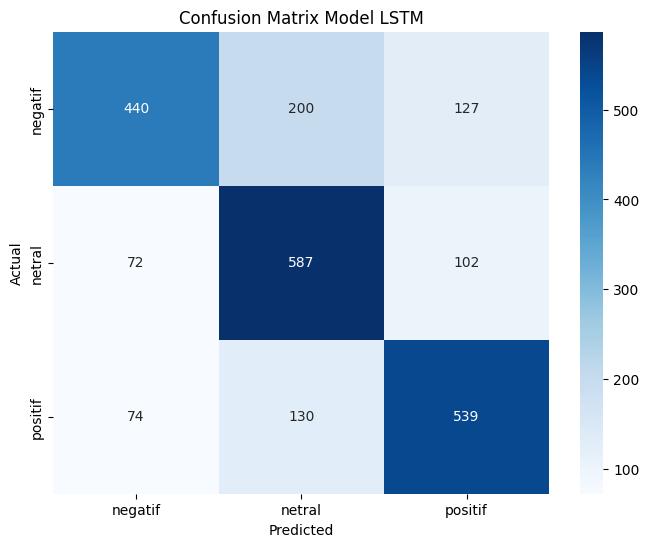

In [30]:
# Prediksi data uji
y_pred = np.argmax(model_lstm.predict(X_test_padded), axis=1)

# Classification Report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix Visual
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Model LSTM')
plt.show()

### GRU (Gated Recurrent Unit)

In [ ]:
# Letakan di fungsi encoder ke variable
le = LabelEncoder()

# Split Data (80% Latih, 20% Uji)
X = df['stemming'].astype(str).values
y = le.fit_transform(df['Sentiment Label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenisasi (Mengubah kata jadi angka indeks)
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding (Menyamakan panjang kalimat)
max_len = 50
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

print('Jumlah data latih:', X_train.shape)
print('Jumlah data test:', X_test.shape)

Jumlah data latih: (9081,)
Jumlah data test: (2271,)


In [ ]:
vocab_size = len(tokenizer.word_index) + 1

# monitor='val_loss': Memantau error pada data validasi
# patience=3: Jika selama 3 epoch tidak ada perbaikan, training berhenti
# restore_best_weights=True: Mengambil bobot terbaik, bukan bobot terakhir saat berhenti
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_gru = Sequential([
    Embedding(vocab_size, 128),
    Bidirectional(GRU(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Memulai Training Model dengan Early Stopping...")
history = model_gru.fit(
    X_train_padded,
    y_train,
    epochs=100,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stop],
    verbose=1
)

Memulai Training Model dengan Early Stopping...
Epoch 1/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4403 - loss: 1.0299 - val_accuracy: 0.6715 - val_loss: 0.7478
Epoch 2/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7440 - loss: 0.6393 - val_accuracy: 0.7107 - val_loss: 0.6909
Epoch 3/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8371 - loss: 0.4303 - val_accuracy: 0.7045 - val_loss: 0.7512
Epoch 4/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8862 - loss: 0.3252 - val_accuracy: 0.7067 - val_loss: 0.8689
Epoch 5/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9101 - loss: 0.2555 - val_accuracy: 0.6847 - val_loss: 1.0254
Epoch 6/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9418 - loss: 0.1750 - val_accuracy: 0.6874 - val_loss: 1.0995
Epoch 7/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9477 - loss: 0.1567 - val_accuracy: 0.6821 - val_loss: 1.2699
Epoch 7: early stopping
Restoring model we

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

     negatif       0.76      0.62      0.68       767
      netral       0.65      0.80      0.72       761
     positif       0.74      0.72      0.73       743

    accuracy                           0.71      2271
   macro avg       0.72      0.71      0.71      2271
weighted avg       0.72      0.71      0.71      2271



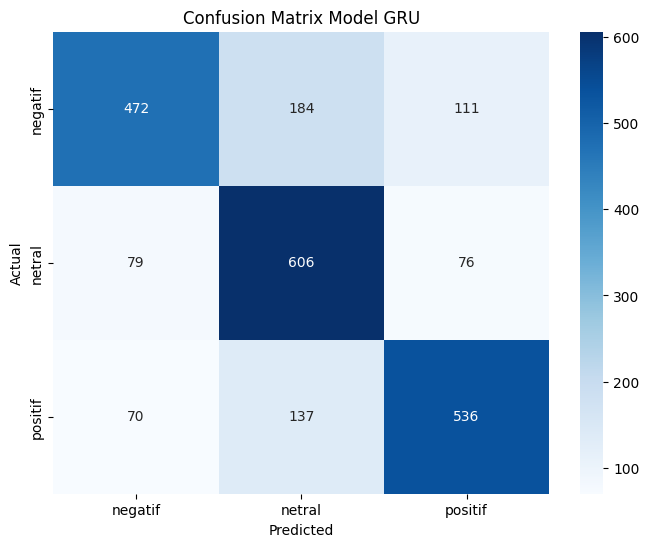

In [ ]:
# Prediksi data uji
y_pred = np.argmax(model_gru.predict(X_test_padded), axis=1)

# Classification Report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix Visual
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Model GRU')
plt.show()

### SVC

In [ ]:
# Vektorisasi teks menggunakan TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train model
svc = SVC(kernel='linear')
svc.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

              precision    recall  f1-score   support

     negatif       0.72      0.68      0.70       767
      netral       0.66      0.68      0.67       761
     positif       0.69      0.70      0.69       743

    accuracy                           0.69      2271
   macro avg       0.69      0.69      0.69      2271
weighted avg       0.69      0.69      0.69      2271



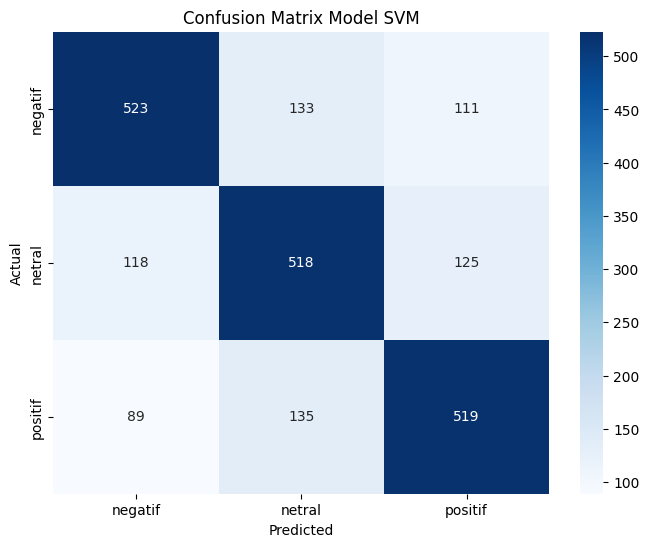

In [ ]:
# Prediksi dan Evaluasi
y_pred_svc = svc.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_svc, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Model SVM')
plt.show()

### Naive Bayes

In [ ]:
# Vektorisasi teks menggunakan TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

              precision    recall  f1-score   support

     negatif       0.65      0.72      0.69       767
      netral       0.69      0.63      0.66       761
     positif       0.71      0.68      0.70       743

    accuracy                           0.68      2271
   macro avg       0.68      0.68      0.68      2271
weighted avg       0.68      0.68      0.68      2271



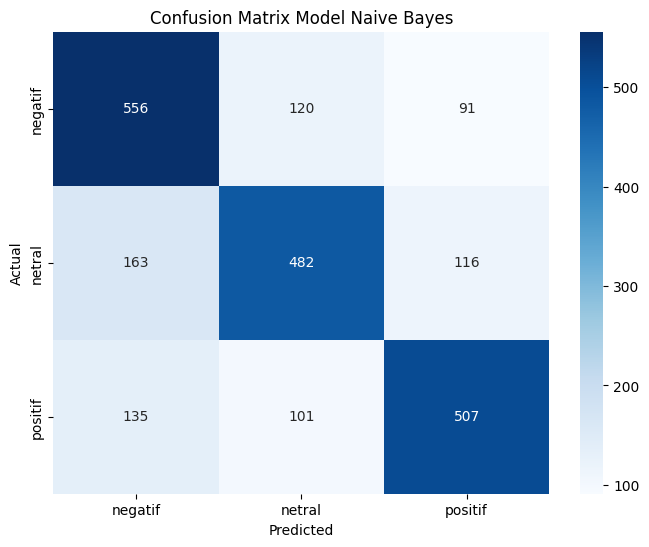

In [ ]:
# Prediksi dan Evaluasi
y_pred_nb = nb.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Model Naive Bayes')
plt.show()

### Logistic Regression

In [ ]:
# Vektorisasi teks menggunakan TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train model
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

LogisticRegression()

              precision    recall  f1-score   support

     negatif       0.72      0.68      0.70       767
      netral       0.66      0.70      0.68       761
     positif       0.69      0.69      0.69       743

    accuracy                           0.69      2271
   macro avg       0.69      0.69      0.69      2271
weighted avg       0.69      0.69      0.69      2271



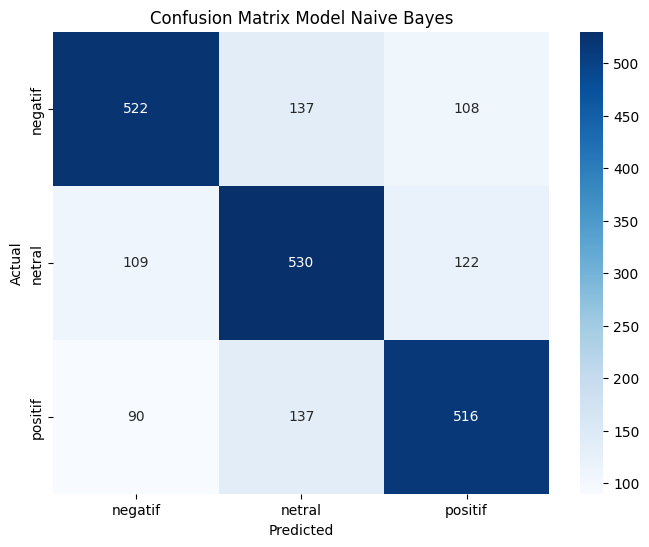

In [ ]:
# Prediksi dan Evaluasi
y_pred_lr = lr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Model Naive Bayes')
plt.show()

### Random Forest

In [ ]:
# Vektorisasi teks menggunakan TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train model
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

     negatif       0.68      0.66      0.67       767
      netral       0.66      0.64      0.65       761
     positif       0.67      0.69      0.68       743

    accuracy                           0.67      2271
   macro avg       0.67      0.67      0.67      2271
weighted avg       0.67      0.67      0.67      2271



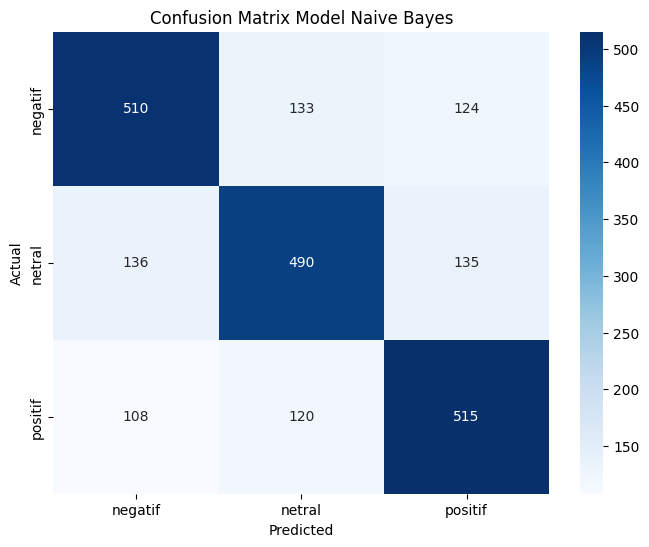

In [ ]:
# Prediksi dan Evaluasi
y_pred_rf = rf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Model Naive Bayes')
plt.show()

## Tuning

### LSTM (Long Short-Term Memory)

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Mengubah teks menjadi urutan angka
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# --- 1. UBAH PADDING KE 'PRE' ---
# LSTM lebih jago baca jika informasi penting ada di akhir sekuens
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='pre')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='pre')

# --- 2. MODIFIKASI FUNGSI MODEL ---
def build_lstm_model(input_length, learning_rate=0.0005, lstm_units=64):
    model = Sequential()
    # Tambahkan Masking agar model mengabaikan angka 0 (padding)
    model.add(Embedding(input_dim=5000, output_dim=128, mask_zero=True))
    model.add(SpatialDropout1D(0.3))

    # Gunakan Bidirectional agar model baca dari depan dan belakang
    # Tambahkan `unroll=True` untuk menonaktifkan CuDNN agar kompatibel dengan padding='pre'
    model.add(Bidirectional(LSTM(lstm_units, dropout=0.3, unroll=True)))

    model.add(Dense(64, activation='relu')) # Tambahan layer padat
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    # Kecilkan Learning Rate agar belajar lebih teliti
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# --- 3. TRAINING DENGAN SETTING BARU ---
model_lstm = build_lstm_model(input_length=X_train_pad.shape[1])

# Tambahkan Batch Size lebih besar agar gradient lebih stabil
history = model_lstm.fit(
    X_train_pad,
    y_train_cat,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
y_pred_probs = model_lstm.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.4002 - loss: 1.0899 - val_accuracy: 0.6472 - val_loss: 0.9223
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6783 - loss: 0.8133 - val_accuracy: 0.6896 - val_loss: 0.7174
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7910 - loss: 0.5626 - val_accuracy: 0.7078 - val_loss: 0.7054
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8442 - loss: 0.4345 - val_accuracy: 0.7034 - val_loss: 0.7582
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8593 - loss: 0.3825 - val_accuracy: 0.6957 - val_loss: 0.8326
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8842 - loss: 0.3163 - val_accuracy: 0.6918 - val_loss: 0.8747
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
71/71 ━━━━━━━━━━━━━━━━━━━━ 60s 428ms/step


              precision    recall  f1-score   support

     negatif       0.74      0.66      0.70       767
      netral       0.65      0.76      0.70       761
     positif       0.73      0.69      0.71       743

    accuracy                           0.70      2271
   macro avg       0.71      0.70      0.70      2271
weighted avg       0.71      0.70      0.70      2271



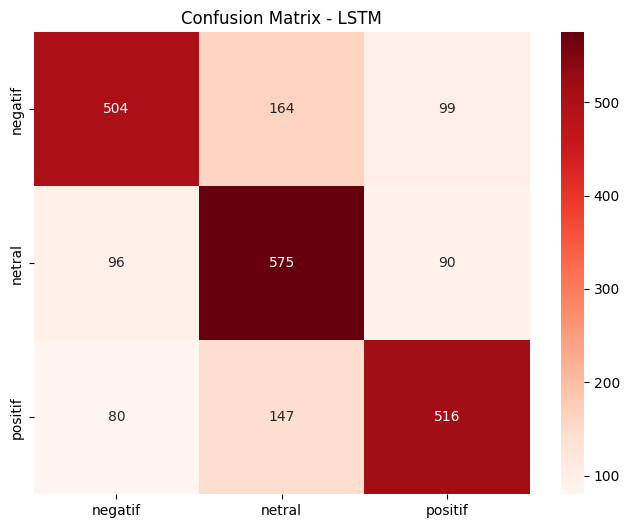

In [ ]:
target_names = ['negatif', 'netral', 'positif']
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Visualisasi
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix - LSTM')
plt.show()

### GRU (Gated Recurrent Unit)

In [ ]:
def build_gru_model(input_length, vocab_size=5000, learning_rate=0.0005):
    model = Sequential()
    # 1. Tambahkan mask_zero agar padding 'pre' tidak mengganggu
    model.add(Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True))
    model.add(SpatialDropout1D(0.3))

    # 2. Gunakan Bidirectional GRU untuk konteks dua arah
    # Tambahkan unroll=True untuk menonaktifkan CuDNN dan memungkinkan padding='pre'
    model.add(Bidirectional(GRU(64, dropout=0.3, unroll=True)))

    # 3. Layer tambahan untuk stabilisasi
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # 4. Output Layer
    model.add(Dense(3, activation='softmax'))

    # 5. Learning rate lebih rendah untuk ketelitian belajar
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Bangun model
model_gru = build_gru_model(X_train_pad.shape[1])

print("Memulai Training GRU dengan Optimasi Baru...")
history_gru = model_gru.fit(
    X_train_pad,
    y_train_cat,
    epochs=50, # Early stopping akan menghentikan jika sudah optimal
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi Final
y_pred_gru_probs = model_gru.predict(X_test_pad)
y_pred_gru_classes = np.argmax(y_pred_gru_probs, axis=1)

Memulai Training GRU dengan Optimasi Baru...
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.3755 - loss: 1.0943 - val_accuracy: 0.5614 - val_loss: 1.0294
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6333 - loss: 0.8882 - val_accuracy: 0.6885 - val_loss: 0.7192
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7917 - loss: 0.5442 - val_accuracy: 0.6912 - val_loss: 0.7236
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8429 - loss: 0.4274 - val_accuracy: 0.6907 - val_loss: 0.7488
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8821 - loss: 0.3224 - val_accuracy: 0.6907 - val_loss: 0.8126
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 376ms/step


              precision    recall  f1-score   support

     negatif       0.74      0.62      0.67       767
      netral       0.63      0.73      0.68       761
     positif       0.69      0.70      0.69       743

    accuracy                           0.68      2271
   macro avg       0.69      0.68      0.68      2271
weighted avg       0.69      0.68      0.68      2271



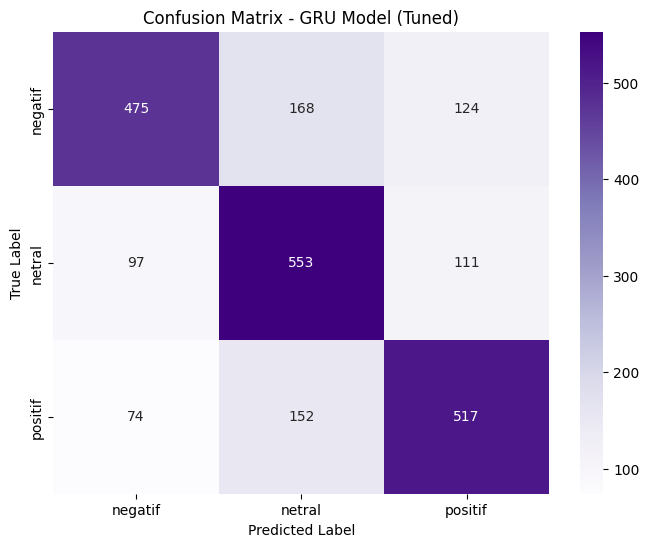

In [ ]:
# Definisi nama label sesuai urutan (0: negatif, 1: netral, 2: positif)
target_names = ['negatif', 'netral', 'positif']
print(classification_report(y_test, y_pred_gru_classes, target_names=target_names))

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
cm_gru = confusion_matrix(y_test, y_pred_gru_classes)
# Menggunakan heatmap Seaborn dengan  warna 'Purples' biar keren
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Purples', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - GRU Model (Tuned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVC

In [ ]:
# Vektorisasi teks menggunakan TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 2. Definisikan parameter grid (Tanpa prefix 'classifier__')
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}

# 3. Inisialisasi GridSearchCV
# n_jobs=-1 agar proses lebih cepat menggunakan semua core CPU
grid_search = GridSearchCV(
    SVC(probability=True),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# 4. Fitting model ke data yang sudah di-tfidf
print("Sedang mencari parameter terbaik...")
grid_search.fit(X_train_tfidf, y_train)

# 5. Hasil Terbaik
print('\nBest parameter: ', grid_search.best_params_)
print('Best score (F1-Macro): ', grid_search.best_score_)

Sedang mencari parameter terbaik...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameter:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best score (F1-Macro):  0.6898578162718504


In [ ]:
# 6. Evaluasi pada data Test
best_svc = grid_search.best_estimator_
y_pred_svc = best_svc.predict(X_test_tfidf)

              precision    recall  f1-score   support

     negatif       0.71      0.69      0.70       767
      netral       0.66      0.68      0.67       761
     positif       0.69      0.69      0.69       743

    accuracy                           0.69      2271
   macro avg       0.69      0.69      0.69      2271
weighted avg       0.69      0.69      0.69      2271



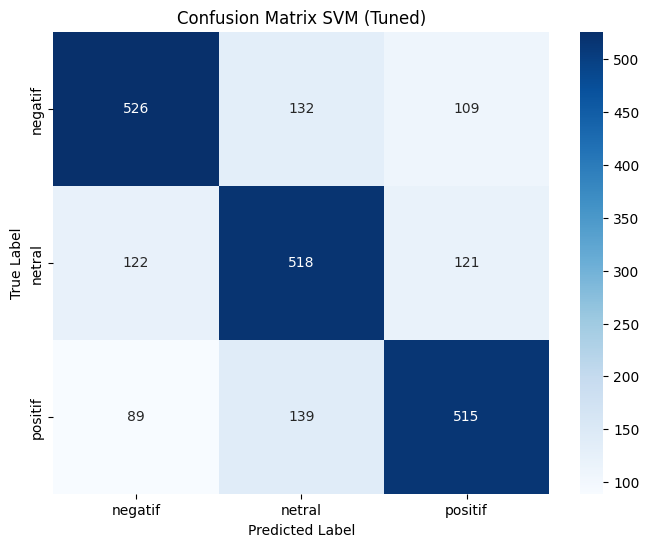

In [ ]:
# Gunakan ConfusionMatrixDisplay agar visualisasi lebih profesional (ada label kelasnya)
print(classification_report(y_test, y_pred_svc, target_names=['negatif', 'netral', 'positif']))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix SVM (Tuned)')
plt.show()

### Naive Bayes

In [ ]:
# Definisikan parameter grid untuk Naive Bayes
param_grid_nb = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
}

# Inisialisasi GridSearchCV untuk Naive Bayes
grid_search_nb = GridSearchCV(
    MultinomialNB(),
    param_grid_nb,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# Latih model ke data TF-IDF
print("Sedang mencari parameter terbaik untuk Naive Bayes...")
grid_search_nb.fit(X_train_tfidf, y_train)

# Hasil
print('\nBest parameter NB: ', grid_search_nb.best_params_)
print('Best score NB (F1-Macro): ', grid_search_nb.best_score_)

Sedang mencari parameter terbaik untuk Naive Bayes...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameter NB:  {'alpha': 1.0}
Best score NB (F1-Macro):  0.6579690469981989


In [ ]:
# Simpan hasil terbaik dan prediksi data baru
best_nb = grid_search_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test_tfidf)

              precision    recall  f1-score   support

     negatif       0.65      0.72      0.69       767
      netral       0.69      0.63      0.66       761
     positif       0.71      0.68      0.70       743

    accuracy                           0.68      2271
   macro avg       0.68      0.68      0.68      2271
weighted avg       0.68      0.68      0.68      2271



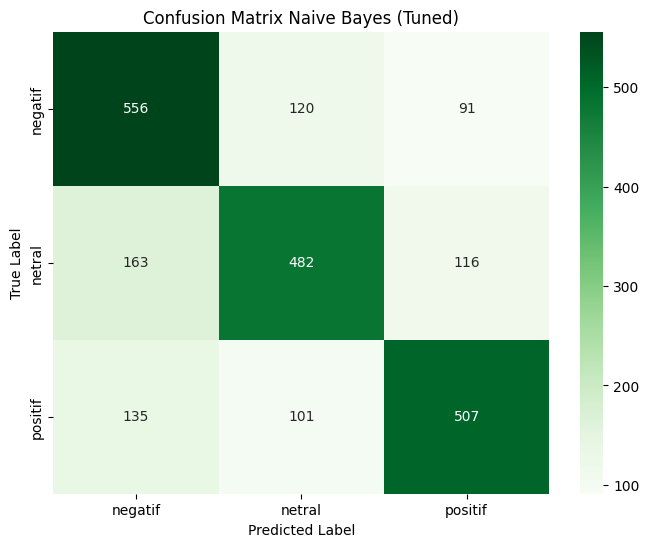

In [ ]:
print(classification_report(y_test, y_pred_nb, target_names=['negatif', 'netral', 'positif']))

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Naive Bayes (Tuned)')
plt.show()

### Logistic Regression

In [ ]:
# Definisikan parameter grid untuk Logistic Regression
# 'solver' adalah algoritma untuk mengoptimalkan bobot
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]
}

# Inisialisasi GridSearchCV
grid_search_lr = GridSearchCV(
    LogisticRegression(),
    param_grid_lr,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# Latih model ke data TF-IDF
print("Sedang mencari parameter terbaik untuk Logistic Regression...")
grid_search_lr.fit(X_train_tfidf, y_train)

# Hasil Terbaik
print('\nBest parameter LR: ', grid_search_lr.best_params_)
print('Best score LR (F1-Macro): ', grid_search_lr.best_score_)

Sedang mencari parameter terbaik untuk Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameter LR:  {'C': 1, 'max_iter': 1000, 'solver': 'lbfgs'}
Best score LR (F1-Macro):  0.6915595113279569


In [ ]:
# Simpan hasil terbaik dan prediksi data baru
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_tfidf)

              precision    recall  f1-score   support

     negatif       0.72      0.68      0.70       767
      netral       0.66      0.70      0.68       761
     positif       0.69      0.69      0.69       743

    accuracy                           0.69      2271
   macro avg       0.69      0.69      0.69      2271
weighted avg       0.69      0.69      0.69      2271



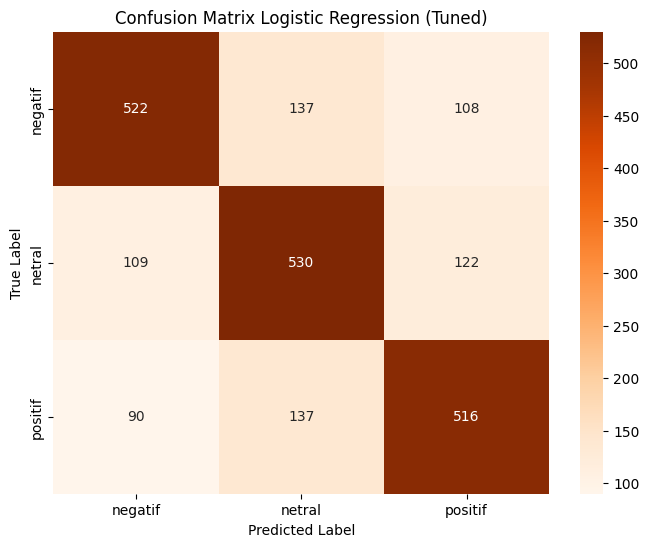

In [ ]:
print(classification_report(y_test, y_pred_lr, target_names=['negatif', 'netral', 'positif']))

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Logistic Regression (Tuned)')
plt.show()

### Random Forest

In [ ]:
# Definisikan parameter grid untuk Random Forest
# n_estimators: Jumlah pohon
# max_depth: Kedalaman pohon untuk menghindari overfitting
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5]
}

# Inisialisasi GridSearchCV
# Gunakan n_jobs=-1 karena Random Forest sangat berat
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# Latih model ke data TF-IDF
print("Sedang mencari parameter terbaik untuk Random Forest...")
grid_search_rf.fit(X_train_tfidf, y_train)

# Hasil Terbaik
print('\nBest parameter RF: ', grid_search_rf.best_params_)
print('Best score RF (F1-Macro): ', grid_search_rf.best_score_)

Sedang mencari parameter terbaik untuk Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameter RF:  {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best score RF (F1-Macro):  0.6507367930861235


In [ ]:
# Simpan hasil terbaik dan prediksi data baru
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_tfidf)

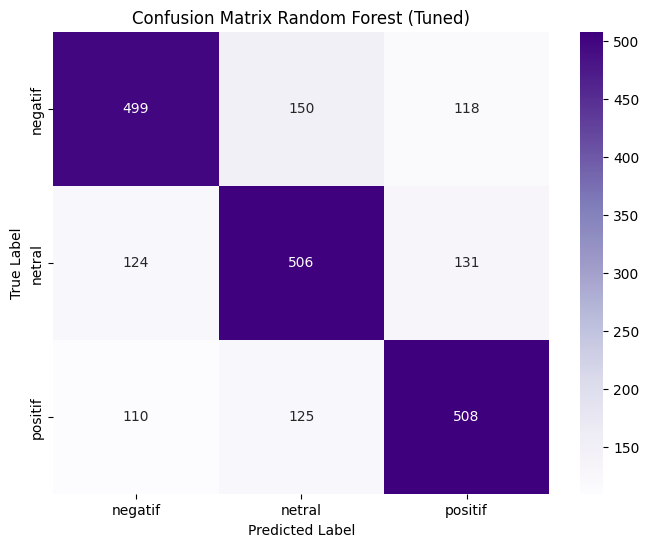


Classification Report Random Forest Final:
              precision    recall  f1-score   support

     negatif       0.68      0.65      0.67       767
      netral       0.65      0.66      0.66       761
     positif       0.67      0.68      0.68       743

    accuracy                           0.67      2271
   macro avg       0.67      0.67      0.67      2271
weighted avg       0.67      0.67      0.67      2271



In [ ]:
print(classification_report(y_test, y_pred_rf, target_names=['negatif', 'netral', 'positif']))

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Purples',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Random Forest (Tuned)')
plt.show()

## Comparison

In [31]:
performance_data = [
    # LSTM
    {'Model': 'LSTM', 'Status': 'Before Tuning', 'F1-score': 0.71, 'Accuracy': 0.71},
    {'Model': 'LSTM', 'Status': 'After Tuning', 'F1-score': 0.70, 'Accuracy': 0.70},
    # GRU
    {'Model': 'GRU', 'Status': 'Before Tuning', 'F1-score': 0.71, 'Accuracy': 0.71},
    {'Model': 'GRU', 'Status': 'After Tuning', 'F1-score': 0.68, 'Accuracy': 0.68},
    # SVC
    {'Model': 'SVC', 'Status': 'Before Tuning', 'F1-score': 0.69, 'Accuracy': 0.69},
    {'Model': 'SVC', 'Status': 'After Tuning', 'F1-score': 0.69, 'Accuracy': 0.69},
    # Naive Bayes
    {'Model': 'Naive Bayes', 'Status': 'Before Tuning', 'F1-score': 0.68, 'Accuracy': 0.68},
    {'Model': 'Naive Bayes', 'Status': 'After Tuning', 'F1-score': 0.68, 'Accuracy': 0.68},
    # Logistic Regression
    {'Model': 'Logistic Regression', 'Status': 'Before Tuning', 'F1-score': 0.69, 'Accuracy': 0.69},
    {'Model': 'Logistic Regression', 'Status': 'After Tuning', 'F1-score': 0.69, 'Accuracy': 0.69},
    # Random Forest
    {'Model': 'Random Forest', 'Status': 'Before Tuning', 'F1-score': 0.67, 'Accuracy': 0.67},
    {'Model': 'Random Forest', 'Status': 'After Tuning', 'F1-score': 0.67, 'Accuracy': 0.67}
]

comparison_df = pd.DataFrame(performance_data)
print("Perbandingan sebelum dan sesudah tuning:")
print(comparison_df.to_markdown(index=False))

Perbandingan sebelum dan sesudah tuning:
| Model               | Status        |   F1-score |   Accuracy |
|:--------------------|:--------------|-----------:|-----------:|
| LSTM                | Before Tuning |       0.71 |       0.71 |
| LSTM                | After Tuning  |       0.7  |       0.7  |
| GRU                 | Before Tuning |       0.71 |       0.71 |
| GRU                 | After Tuning  |       0.68 |       0.68 |
| SVC                 | Before Tuning |       0.69 |       0.69 |
| SVC                 | After Tuning  |       0.69 |       0.69 |
| Naive Bayes         | Before Tuning |       0.68 |       0.68 |
| Naive Bayes         | After Tuning  |       0.68 |       0.68 |
| Logistic Regression | Before Tuning |       0.69 |       0.69 |
| Logistic Regression | After Tuning  |       0.69 |       0.69 |
| Random Forest       | Before Tuning |       0.67 |       0.67 |
| Random Forest       | After Tuning  |       0.67 |       0.67 |


In [33]:
# y_pred di sini berisi angka 0, 1, atau 2
y_pred_labels_final = le.inverse_transform(y_pred)

# Lakukan inverse transform untuk y_test agar muncul kata 'negatif', 'netral', 'positif'
y_test_labels_final = le.inverse_transform(y_test)

# Buat DataFrame Perbandingan
comparison_df_lstm = pd.DataFrame({
    'Actual Sentiment': y_test_labels_final,
    'Predicted Sentiment (LSTM)': y_pred_labels_final,
    'Comment': X_test
})

# Cek distribusi hasil prediksi
print("Distribusi Prediksi pada Data Test:")
print(comparison_df_lstm['Predicted Sentiment (LSTM)'].value_counts())
print('\nData test actual')
print(pd.Series(y_test_labels_final).value_counts())

print("\nPerbandingan Sentimen Aktual vs. Prediksi Model LSTM:")
comparison_df_lstm.head(20)

Distribusi Prediksi pada Data Test:
Predicted Sentiment (LSTM)
netral     917
positif    768
negatif    586
Name: count, dtype: int64

Data test actual
negatif    767
netral     761
positif    743
Name: count, dtype: int64

Perbandingan Sentimen Aktual vs. Prediksi Model LSTM:


,Actual Sentiment,Predicted Sentiment (LSTM),Comment
0,negatif,netral,pohon sawit sama hutan lindungdasar lansia
1,positif,positif,untung aku pilih wkwk
2,positif,positif,kira tuhan serta beri kuat tiap sungguh cinta ...
3,netral,positif,bagus aceh merdeka kaya alam rampok jabat maling
4,positif,netral,zi hidup dekengane pusat
5,netral,netral,prabowo milik lahan sumatra luas tiga kali sin...
6,negatif,negatif,sedih kasihan indonesia alam manusia siksa gar...
7,positif,positif,betul turun langsung lapang
8,positif,positif,mantap abang masuk
9,netral,netral,gubernur sumut hehehe


In [32]:
# y_pred di sini berisi angka 0, 1, atau 2
y_pred_labels_final = le.inverse_transform(y_pred)

# Lakukan inverse transform untuk y_test agar muncul kata 'negatif', 'netral', 'positif'
y_test_labels_final = le.inverse_transform(y_test)

# Buat DataFrame Perbandingan
comparison_df_lstm = pd.DataFrame({
    'Actual Sentiment': y_test_labels_final,
    'Predicted Sentiment (LSTM)': y_pred_labels_final,
    'Comment': X_test
})

# Cek distribusi hasil prediksi
print("Distribusi Prediksi pada Data Test:")
print(comparison_df_lstm['Predicted Sentiment (LSTM)'].value_counts())
print('\nData test actual')
print(pd.Series(y_test_labels_final).value_counts())

print("\nPerbandingan Sentimen Aktual vs. Prediksi Model LSTM:")
comparison_df_lstm.tail(20)

Distribusi Prediksi pada Data Test:
Predicted Sentiment (LSTM)
netral     917
positif    768
negatif    586
Name: count, dtype: int64

Data test actual
negatif    767
netral     761
positif    743
Name: count, dtype: int64

Perbandingan Sentimen Aktual vs. Prediksi Model LSTM:


,Actual Sentiment,Predicted Sentiment (LSTM),Comment
2251,negatif,negatif,malu bukan kultur jabat indonesia negara asia ...
2252,netral,netral,korban ribu status bencana nasional aktif
2253,positif,positif,gila berani betul kawal koi cok
2254,negatif,netral,cari versi konspirasi min
2255,positif,positif,kapitalis suka referendum kayak suka referendu...
2256,netral,positif,dedi corbucer dukung rezim
2257,negatif,negatif,salah siapa salah pilih masa pemiu
2258,netral,netral,wowo peduli citra dunia kirim pasu aman pbb lu...
2259,negatif,positif,sulit bahlil tum partai bpk lu jabat apa parpo...
2260,netral,positif,selamat bagi dosa


## Save Best Model

In [34]:
# Simpan Model LSTM (.h5)
model_lstm.save('model_sentimen_lstm.h5')

# Simpan Tokenizer (.pkl) agar input user diubah jadi angka yang sama
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Simpan LabelEncoder (.pkl) agar angka 0,1,2 kembali jadi kata
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Semua file sudah disimpan!")

Semua file sudah disimpan!


## Deploy

In [36]:
import gradio as gr
import tensorflow as tf
import numpy as np
import pickle

# Load kembali file yang sudah disimpan
model = tf.keras.models.load_model('model_sentimen_lstm.h5')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Fungsi Prediksi
def prediksi_sentimen(teks):
    # Tokenisasi & Padding
    sekuens = tokenizer.texts_to_sequences([teks])
    padded = pad_sequences(sekuens, maxlen=50, padding='post')

    # Prediksi
    pred_prob = model.predict(padded, verbose=0)[0] # Ambil array probabilitas pertama
    pred_idx = np.argmax(pred_prob) # Ambil indeks dengan probabilitas tertinggi
    label = le.inverse_transform([pred_idx])[0] # Ubah indeks menjadi label sentimen
    score = pred_prob[pred_idx] * 100 # Ambil skor probabilitas dan ubah ke persentase

    # Memberikan skor probabilitas untuk tampilan
    return f"Sentimen: {label.capitalize()} ({score:.2f}%)"

#  Tampilan Gradio
demo = gr.Interface(
    fn=prediksi_sentimen,
    inputs=gr.Textbox(lines=2, placeholder="Masukkan komentar YouTube di sini..."),
    outputs="text",
    title="Analisis Sentimen Komentar YouTube - Model LSTM",
    description="Masukkan komentar untuk mengetahui apakah sentimennya Negatif, Netral, atau Positif beserta tingkat keyakinan model."
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://58a2d181ae6dda1782.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
